In [1]:
!pip install gym

In [2]:
!pip install gym==0.19

In [3]:
!pip install atari-py

In [4]:
!python -m atari_py.import_roms '/Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms'

copying koolaid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Kool-Aid Man (Kool Aid Pitcher Man) (1983) (M Network, Stephen Tatsumi, Jane Terjung - Kool Aid) (MT4648) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/koolaid.bin
copying alien.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/alien.bin
copying demon_attack.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Demon Attack (Death from Above) (1982) (Imagic, Rob Fulop) (720000-200, 720101-1B, 720101-1C, IA3200, IA3200C, IX-006-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/demon_attack.bin
copying crazy_climber.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Crazy Climber (1983) (Atari - Rokl

copying space_invaders.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Space Invaders (1980) (Atari, Richard Maurer - Sears) (CX2632 - 49-75153) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/space_invaders.bin
copying up_n_down.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Up 'n Down (1984) (SEGA - Beck-Tech, Steve Beck, Phat Ho) (009-01) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/up_n_down.bin
copying galaxian.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Galaxian (1983) (Atari - GCC, Mark Ackerman, Tom Calderwood, Glenn Parker) (CX2684) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/galaxian.bin
copying riverraid.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/River Raid (1982) (Activision, Carol Shaw) (AX-020, AX-020-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python

copying asteroids.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Asteroids (1981) (Atari, Brad Stewart - Sears) (CX2649 - 49-75163) [no copyright] ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/asteroids.bin
copying frogger.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Frogger (1982) (Parker Brothers, Ed English, David Lamkins) (PB5300) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/frogger.bin
copying chopper_command.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Chopper Command (1982) (Activision, Bob Whitehead) (AX-015, AX-015-04) ~.bin to /Users/srikanth/opt/anaconda3/lib/python3.9/site-packages/atari_py/atari_roms/chopper_command.bin
copying time_pilot.bin from /Users/srikanth/Downloads/Bigdata_test2_1_srikanth/Roms/ROMS/Time Pilot (1983) (Coleco - Woodside Design Associates, Harley H. Puthuff Jr.) (2663) ~.bin to /Users/srikanth/opt

In [5]:
""" Trains an agent with (stochastic) Policy Gradients on Pong. Uses OpenAI Gym. """
import numpy as np
import pickle
import gym
import time
start_time=time.time()

# hyperparameters
H = 200 # number of hidden layer neurons
batch_size = 10 # every how many episodes to do a param update?
learning_rate = 0.00008
gamma = 0.99 # discount factor for reward
decay_rate = 0.99 # decay factor for RMSProp leaky sum of grad^2
resume = False # resume from previous checkpoint?
render = False

# model initialization
D = 80 * 80 # input dimensionality: 80x80 grid
if resume:
    model = pickle.load(open('save_200_1e-5.p', 'rb'))
else:
    model = {}
    model['W1'] = np.random.randn(H,D) / np.sqrt(D) # "Xavier" initialization
    model['W2'] = np.random.randn(H) / np.sqrt(H)

grad_buffer = { k : np.zeros_like(v) for k,v in model.items() } # update buffers that add up gradients over a batch
rmsprop_cache = { k : np.zeros_like(v) for k,v in model.items() } # rmsprop memory

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x)) # sigmoid "squashing" function to interval [0,1]

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(model['W2'], h)
    p = sigmoid(logp)
    return p, h # return probability of taking action 2, and hidden state

def policy_backward(eph, epdlogp):
    """ backward pass. (eph is array of intermediate hidden states) """
    dW2 = np.dot(eph.T, epdlogp).ravel()
    dh = np.outer(epdlogp, model['W2'])
    dh[eph <= 0] = 0 # backpro prelu
    dW1 = np.dot(dh.T, epx)
    return {'W1':dW1, 'W2':dW2}

env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
xs,hs,dlogps,drs = [],[],[],[]
running_reward = None
reward_sum = 0
episode_number = 0
while True:
    if render: env.render()

  # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(D)
    prev_x = cur_x

  # forward the policy network and sample an action from the returned probability
    aprob, h = policy_forward(x)
    action = 2 if np.random.uniform() < aprob else 3 # roll the dice!

  # record various intermediates (needed later for backprop)
    xs.append(x) # observation
    hs.append(h) # hidden state
    y = 1 if action == 2 else 0 # a "fake label"
    dlogps.append(y - aprob) # grad that encourages the action that was taken to be taken (see http://cs231n.github.io/neural-networks-2/#losses if confused)

  # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    reward_sum += reward

    drs.append(reward) # record reward (has to be done after we call step() to get reward for previous action)

    if done: # an episode finished
        episode_number += 1

    # stack together all inputs, hidden states, action gradients, and rewards for this episode
        epx = np.vstack(xs)
        eph = np.vstack(hs)
        epdlogp = np.vstack(dlogps)
        epr = np.vstack(drs)
        xs,hs,dlogps,drs = [],[],[],[] # reset array memory

    # compute the discounted reward backwards through time
        discounted_epr = discount_rewards(epr)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
        discounted_epr -= np.mean(discounted_epr)
        discounted_epr /= np.std(discounted_epr)

        epdlogp *= discounted_epr # modulate the gradient with advantage (PG magic happens right here.)
        grad = policy_backward(eph, epdlogp)
        for k in model: grad_buffer[k] += grad[k] # accumulate grad over batch

    # perform rmsprop parameter update every batch_size episodes
        if episode_number % batch_size == 0:
            for k,v in model.items():
                g = grad_buffer[k] # gradient
                rmsprop_cache[k] = decay_rate * rmsprop_cache[k] + (1 - decay_rate) * g**2
                model[k] += learning_rate * g / (np.sqrt(rmsprop_cache[k]) + 1e-5)
                grad_buffer[k] = np.zeros_like(v) # reset batch gradient buffer

    # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print('resetting env. episode reward total was {}. running mean: {}'.format(reward_sum, running_reward))
        if episode_number % 100 == 0: pickle.dump(model, open('save_200_1e-5.p', 'wb'))
        reward_sum = 0
        observation = env.reset() # reset env
        prev_x = None
        if running_reward>=-19:
            break
    if reward != 0: # Pong has either +1 or -1 reward exactly when game ends.
        print ('ep {}: game finished, reward: {}'.format(episode_number, reward) + ('' if reward == -1 else ' !!!!!!!!'))
end_time=time.time()
td_model=end_time-start_time
print('Time difference for model is %s seconds:' %(td_model))

        

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_1164/293231280.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: 1.0 !!!!!!!!
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
ep 0: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: game finished, reward: -1.0
ep 1: g

ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
ep 10: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.05687976251636
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: game finished, reward: -1.0
ep 11: gam

resetting env. episode reward total was -20.0. running mean: -20.07040499956355
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: 1.0 !!!!!!!!
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
ep 20: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.069700949567913
ep 21: game finished, reward: -1.0
ep 21: game finished, rewa

ep 29: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.10279071356048
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: 1.0 !!!!!!!!
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
ep 30: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.101762806424876
ep 31: game finished, rewa

ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
ep 39: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.07509422700112
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: game finished, reward: -1.0
ep 40: gam

ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
ep 49: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.076948270460026
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: game finished, reward: -1.0
ep 50: ga

ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: 1.0 !!!!!!!!
ep 59: game finished, reward: -1.0
ep 59: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.098028965616603
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
ep 60: game finished, reward: -1.0
e

resetting env. episode reward total was -20.0. running mean: -20.13778281293676
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
ep 69: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.146404984807393
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0
ep 70: game finished, reward: -1.0

ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
ep 78: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.164207220885988
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
ep 79: game finished, reward: -1.0
resetting env. episode reward total was -21.

ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
ep 88: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.205982557174426
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: game finished, reward: -1.0
ep 89: ga

ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
ep 98: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.272584203985158
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: -1.0
ep 99: game finished, reward: 1.0 !!!!!!!!
ep 99: game finished, reward: 1.0 !!!!!!!!
ep 99: game finished, reward

ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
ep 108: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.314547194577173
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finished, reward: -1.0
ep 109: game finish

ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
ep 118: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.342598703147708
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finished, reward: -1.0
ep 119: game finish

ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
ep 128: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35819384555922
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finished, reward: -1.0
ep 129: game finishe

ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
ep 137: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.36574394785385
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: 1.0 !!!!!!!!
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: 1.0 !!!!!!!!
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: 1.0 !!!!!!!!
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: -1.0
ep 138: game finished, reward: 1.0 !!!!!!!!
ep 138: game finished, reward: -1.0
ep 138: game finished, r

ep 146: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.297014350614337
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: 1.0 !!!!!!!!
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
ep 147: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.294044207108193
ep

ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
ep 156: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.316467604244338
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finished, reward: -1.0
ep 157: game finish

ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: 1.0 !!!!!!!!
ep 166: game finished, reward: 1.0 !!!!!!!!
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: 1.0 !!!!!!!!
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
ep 166: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.27630543510631
ep 167: game finished, reward: -1.0
ep 167: game finished, reward: -

ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
ep 175: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.28142162311329
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: 1.0 !!!!!!!!
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game finished, reward: -1.0
ep 176: game

ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
ep 185: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.293153861387893
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finished, reward: -1.0
ep 186: game finish

ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
ep 194: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.305474881060633
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
ep 195: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
ep 204: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.30529924837651
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finished, reward: -1.0
ep 205: game finishe

ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
ep 214: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.333491440643563
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finished, reward: -1.0
ep 215: game finish

ep 223: game finished, reward: -1.0
ep 223: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.35278962788914
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: 1.0 !!!!!!!!
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
ep 224: game finished, reward: -1.0
resetting env. episode reward total was -20.0. r

ep 233: game finished, reward: 1.0 !!!!!!!!
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
ep 233: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.32867033879204
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game finished, reward: -1.0
ep 234: game

resetting env. episode reward total was -21.0. running mean: -20.348783312152165
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
ep 243: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.355295479030644
ep 244: game finished, reward: -1.0
ep 244: game finished, reward: -1.0
ep 244: ga

ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
ep 252: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.31554784496739
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finished, reward: -1.0
ep 253: game finishe

ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
ep 261: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.269904310225943
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finished, reward: -1.0
ep 262: game finish

ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: 1.0 !!!!!!!!
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: 1.0 !!!!!!!!
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: 1.0 !!!!!!!!
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
ep 271: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.29981454512716
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -1.0
ep 272: game finished, reward: -

ep 280: game finished, reward: -1.0
ep 280: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.322327947944476
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
ep 281: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.329104668465032
ep 282: ga

ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
ep 290: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.32918892119354
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finished, reward: -1.0
ep 291: game finishe

ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
ep 300: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.355371600721565
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finished, reward: -1.0
ep 301: game finish

ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
ep 309: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.343555044653822
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finished, reward: -1.0
ep 310: game finish

ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
ep 319: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.320611740190333
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finished, reward: -1.0
ep 320: game finish

ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
ep 328: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34141302650262
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: 1.0 !!!!!!!!
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
ep 329: game finished, reward: -1.0
resetting en

ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
ep 338: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.37593967336084
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finished, reward: -1.0
ep 339: game finishe

ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
ep 348: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.378258603176388
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finished, reward: -1.0
ep 349: game finish

ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
ep 357: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.394369304551027
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finished, reward: -1.0
ep 358: game finish

ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
ep 367: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.403937148002697
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finished, reward: -1.0
ep 368: game finish

ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
ep 376: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.39889091673469
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: 1.0 !!!!!!!!
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: 1.0 !!!!!!!!
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 377: game finished, reward: -1.0
ep 3

ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: 1.0 !!!!!!!!
ep 386: game finished, reward: 1.0 !!!!!!!!
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
ep 386: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.361015847652588
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 387: game finished, reward: -1.0
ep 

ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
ep 395: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.348340313868917
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finished, reward: -1.0
ep 396: game finish

ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
ep 405: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.363097315881117
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finished, reward: -1.0
ep 406: game finish

ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: -1.0
ep 415: game finished, reward: 1.0 !!!!!!!!
ep 415: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.385556291514604
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: game finished, reward: -1.0
ep 416: gam

ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
ep 424: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.409280273196778
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: 1.0 !!!!!!!!
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: game finished, reward: -1.0
ep 425: gam

ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
ep 434: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.438080394826883
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finished, reward: -1.0
ep 435: game finish

ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
ep 444: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.491809981485417
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finished, reward: -1.0
ep 445: game finish

resetting env. episode reward total was -21.0. running mean: -20.487908454549608
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
ep 454: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.493029370004113
ep 455: game finished, reward: -1.0
ep 455: game finished, reward: -1.0
ep 455: ga

ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: 1.0 !!!!!!!!
ep 463: game finished, reward: -1.0
ep 463: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.468926347092818
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: game finished, reward: -1.0
ep 464: gam

ep 472: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.4379861073628
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: 1.0 !!!!!!!!
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: 1.0 !!!!!!!!
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: 1.0 !!!!!!!!
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1.0
ep 473: game finished, reward: -1

ep 482: game finished, reward: -1.0
ep 482: game finished, reward: -1.0
ep 482: game finished, reward: -1.0
ep 482: game finished, reward: -1.0
ep 482: game finished, reward: -1.0
ep 482: game finished, reward: -1.0
ep 482: game finished, reward: -1.0
ep 482: game finished, reward: -1.0
ep 482: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.43587109174513
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finished, reward: -1.0
ep 483: game finishe

ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
ep 492: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.441584185786002
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finished, reward: -1.0
ep 493: game finish

ep 501: game finished, reward: -1.0
ep 501: game finished, reward: -1.0
ep 501: game finished, reward: -1.0
ep 501: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.4317497416489
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: 1.0 !!!!!!!!
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game finished, reward: -1.0
ep 502: game 

ep 511: game finished, reward: 1.0 !!!!!!!!
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
ep 511: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.44772882627424
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: -1.0
ep 512: game finished, reward: 1.0 !!!!!!!!
ep 5

resetting env. episode reward total was -20.0. running mean: -20.429280607653844
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
ep 521: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.434987801577307
ep 522: game finished, reward: -1.0
ep 522: game finished, reward: -1.0
ep 522: ga

ep 530: game finished, reward: -1.0
ep 530: game finished, reward: -1.0
ep 530: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.474436810208218
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
ep 531: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
ep 540: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.448687724386374
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finished, reward: -1.0
ep 541: game finish

ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: 1.0 !!!!!!!!
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: 1.0 !!!!!!!!
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
ep 550: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.453048166314172
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 551: game finished, reward: -1.0
ep 

ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
ep 559: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.470846076385193
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: 1.0 !!!!!!!!
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: 1.0 !!!!!!!!
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 560: game finished, reward: -1.0
ep 

ep 568: game finished, reward: -1.0
ep 568: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -20.391097447124668
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
ep 569: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.397186472653424
ep

ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
ep 578: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.420976138209173
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finished, reward: -1.0
ep 579: game finish

ep 587: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.3948648368894
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
ep 588: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.400916188520508
ep 589: game finished, reward: -1.0
ep 589: game

ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
ep 597: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.394495904028243
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finished, reward: -1.0
ep 598: game finish

ep 607: game finished, reward: 1.0 !!!!!!!!
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
ep 607: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.40367409865974
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game finished, reward: -1.0
ep 608: game

ep 616: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.42642715340544
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
ep 617: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.43216288187139
ep 618: game finished, reward: -1.0
ep 618: game

ep 626: game finished, reward: -1.0
ep 626: game finished, reward: 1.0 !!!!!!!!
ep 626: game finished, reward: -1.0
ep 626: game finished, reward: -1.0
ep 626: game finished, reward: -1.0
ep 626: game finished, reward: -1.0
ep 626: game finished, reward: -1.0
ep 626: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.44225905872811
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game finished, reward: -1.0
ep 627: game

ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: 1.0 !!!!!!!!
ep 636: game finished, reward: 1.0 !!!!!!!!
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: 1.0 !!!!!!!!
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
ep 636: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.39823478464308
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -1.0
ep 637: game finished, reward: -

ep 645: game finished, reward: -1.0
ep 645: game finished, reward: -1.0
ep 645: game finished, reward: -1.0
ep 645: game finished, reward: -1.0
ep 645: game finished, reward: -1.0
ep 645: game finished, reward: -1.0
ep 645: game finished, reward: -1.0
ep 645: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.382538562857672
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: -1.0
ep 646: game finished, reward: 1.0 !!!!!!!!
ep 646: gam

resetting env. episode reward total was -21.0. running mean: -20.331313119935878
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
ep 655: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.33799998873652
ep 656: game finished, reward: -1.0
ep 656: game finished, reward: -1.0
ep 656: gam

ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: 1.0 !!!!!!!!
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
ep 664: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.299250272914808
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: 1.0 !!!!!!!!
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 665: game finished, reward: -1.0
ep 

ep 673: game finished, reward: -1.0
ep 673: game finished, reward: -1.0
ep 673: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.293262541757656
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: 1.0 !!!!!!!!
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
ep 674: game finished, reward: -1.0
resetting e

ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
ep 683: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.256491743645128
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finished, reward: -1.0
ep 684: game finish

ep 692: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.301865770594276
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: 1.0 !!!!!!!!
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
ep 693: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.298847112888332
ep

ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
ep 702: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.291935437057266
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finished, reward: -1.0
ep 703: game finish

ep 711: game finished, reward: -1.0
ep 711: game finished, reward: -1.0
ep 711: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.27542055236171
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
ep 712: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running m

ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
ep 721: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.29685309769387
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finished, reward: -1.0
ep 722: game finishe

ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: 1.0 !!!!!!!!
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
ep 731: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.316132465033025
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: game finished, reward: -1.0
ep 732: gam

ep 740: game finished, reward: -1.0
ep 740: game finished, reward: -1.0
ep 740: game finished, reward: -1.0
ep 740: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.346159410319533
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: 1.0 !!!!!!!!
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: game finished, reward: -1.0
ep 741: gam

ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
ep 750: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.351206663331887
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finished, reward: -1.0
ep 751: game finish

ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: 1.0 !!!!!!!!
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
ep 760: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.37422128245313
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game finished, reward: -1.0
ep 761: game

ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
ep 769: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.342935687864593
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: 1.0 !!!!!!!!
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: game finished, reward: -1.0
ep 770: gam

ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
ep 779: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.349162583540814
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finished, reward: -1.0
ep 780: game finish

ep 788: game finished, reward: -1.0
ep 788: game finished, reward: -1.0
ep 788: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.347905222264835
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
ep 789: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
ep 798: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.3063015481658
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished, reward: -1.0
ep 799: game finished

ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
ep 807: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.347073846217686
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
ep 808: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running 

ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
ep 817: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.381057189791484
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finished, reward: -1.0
ep 818: game finish

ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: 1.0 !!!!!!!!
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
ep 827: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.392473422604283
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: game finished, reward: -1.0
ep 828: gam

ep 836: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.435212993244306
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
ep 837: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.440860863311865
ep 838: game finished, reward: -1.0
ep 838: ga

ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
ep 846: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.403495860971415
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finished, reward: -1.0
ep 847: game finish

ep 855: game finished, reward: -1.0
ep 855: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.406947578310003
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: 1.0 !!!!!!!!
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
ep 856: game finished, reward: -1.0
resetting env. episode reward total was -20.0. 

ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: 1.0 !!!!!!!!
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
ep 865: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.416084245316156
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: 1.0 !!!!!!!!
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: 1.0 !!!!!!!!
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: 1.0 !!!!!!!!
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, reward: -1.0
ep 866: game finished, 

ep 874: game finished, reward: -1.0
ep 874: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.382113990204473
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
ep 875: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.38829285030243
ep 876: gam

ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: 1.0 !!!!!!!!
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
ep 884: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.373650454563144
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: game finished, reward: -1.0
ep 885: gam

ep 893: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.378411927189894
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: 1.0 !!!!!!!!
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: -1.0
ep 894: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was

ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: 1.0 !!!!!!!!
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
ep 903: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.35240859293925
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game finished, reward: -1.0
ep 904: game

resetting env. episode reward total was -21.0. running mean: -20.360666685254728
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
ep 913: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36706001840218
ep 914: game finished, reward: -1.0
ep 914: game finished, reward: -1.0
ep 914: gam

ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
ep 922: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.345134135012348
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finished, reward: -1.0
ep 923: game finish

ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
ep 932: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.369801782526753
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finished, reward: -1.0
ep 933: game finish

ep 941: game finished, reward: -1.0
ep 941: game finished, reward: -1.0
ep 941: game finished, reward: -1.0
ep 941: game finished, reward: -1.0
ep 941: game finished, reward: -1.0
ep 941: game finished, reward: -1.0
ep 941: game finished, reward: -1.0
ep 941: game finished, reward: -1.0
ep 941: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.326480188505744
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finished, reward: -1.0
ep 942: game finish

ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: 1.0 !!!!!!!!
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
ep 951: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.334178594374592
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: game finished, reward: -1.0
ep 952: gam

ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
ep 960: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.353624040024382
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: 1.0 !!!!!!!!
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: game finished, reward: -1.0
ep 961: gam

ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
ep 970: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.359016408058693
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finished, reward: -1.0
ep 971: game finish

ep 979: game finished, reward: -1.0
ep 979: game finished, reward: -1.0
ep 979: game finished, reward: -1.0
ep 979: game finished, reward: -1.0
ep 979: game finished, reward: -1.0
ep 979: game finished, reward: -1.0
ep 979: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.33816275999623
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: 1.0 !!!!!!!!
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: 1.0 !!!!!!!!
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 980: game finished, reward: -1.0
ep 9

ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
ep 989: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.364156117619626
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finished, reward: -1.0
ep 990: game finish

ep 998: game finished, reward: -1.0
ep 998: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36236101233715
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
ep 999: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.368737402213778
ep 1000: ga

ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
ep 1008: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.404203282286673
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward: -1.0
ep 1009: game finished, reward:

ep 1017: game finished, reward: 1.0 !!!!!!!!
ep 1017: game finished, reward: -1.0
ep 1017: game finished, reward: 1.0 !!!!!!!!
ep 1017: game finished, reward: -1.0
ep 1017: game finished, reward: -1.0
ep 1017: game finished, reward: -1.0
ep 1017: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.369251385108644
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: 1.0 !!!!!!!!
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018: game finished, reward: -1.0
ep 1018

ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: 1.0 !!!!!!!!
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: 1.0 !!!!!!!!
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
ep 1027: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.38129963943651
ep 1028: game finished, reward: -1.0
ep 1028: game finished, reward: -1.0
ep 1028: game fi

ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
ep 1036: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.4054025596009
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: 1.0 !!!!!!!!
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: -1.0
ep 1037: game finished, reward: 1.0 !!!!!!!!
ep 1037: game finished, reward: -1.0
ep 1037: game fin

ep 1045: game finished, reward: -1.0
ep 1045: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.40915428750323
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
ep 1046: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.4150

ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
ep 1055: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.408379866504756
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward: -1.0
ep 1056: game finished, reward:

ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
ep 1064: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.43101414200051
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: -1.0
ep 1065: game finished, reward: 

ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: 1.0 !!!!!!!!
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
ep 1074: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.40826411174748
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, reward: -1.0
ep 1075: game finished, 

ep 1082: game finished, reward: -1.0
ep 1082: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.289480930847308
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
ep 1083: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.296

ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: 1.0 !!!!!!!!
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
ep 1092: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.309848535418805
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished, reward: -1.0
ep 1093: game finished,

ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
ep 1101: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.31188731915191
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: -1.0
ep 1102: game finished, reward: 

ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
ep 1110: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26580447590775
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: -1.0
ep 1111: game finished, reward: 

resetting env. episode reward total was -21.0. running mean: -20.2914426172643
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
ep 1120: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.298528191091656
ep 1121: game finished, reward: -1.0
ep 1121: game finished, re

ep 1128: game finished, reward: -1.0
ep 1128: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.227804216014842
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
ep 1129: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.235

ep 1137: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.1984951213602
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: 1.0 !!!!!!!!
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
ep 1138: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -

ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
ep 1147: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.256770735306947
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: 1.0 !!!!!!!!
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished, reward: -1.0
ep 1148: game finished,

ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: -1.0
ep 1156: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.243963692471887
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished, reward: -1.0
ep 1157: game finished,

resetting env. episode reward total was -19.0. running mean: -20.241693488368192
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
ep 1166: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.24927655348451
ep 1167: game finished, reward: -1.0
ep 1167: game finished, r

ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
ep 1175: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.266057875974457
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward: -1.0
ep 1176: game finished, reward:

ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: 1.0 !!!!!!!!
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
ep 1184: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24198196310561
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, reward: -1.0
ep 1185: game finished, 

ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
ep 1193: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25949314185
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.0
ep 1194: game finished, reward: -1.

ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
ep 1203: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.302335969150697
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: 1.0 !!!!!!!!
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished, reward: -1.0
ep 1204: game finished,

ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
ep 1212: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.305207913847855
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: 1.0 !!!!!!!!
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: 1.0 !!!!!!!!
ep 1213: game finished, reward: -1.0
ep 1213: game finished, reward: -1.0
ep 1213: game f

resetting env. episode reward total was -21.0. running mean: -20.32782075099832
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
ep 1222: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.33454254348834
ep 1223: game finished, reward: -1.0
ep 1223: game finished, re

ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
ep 1231: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35490278714837
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: 1.0 !!!!!!!!
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, reward: -1.0
ep 1232: game finished, 

ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
ep 1240: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.353903073375843
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
ep 1241: game finished, reward: -1.0
resetting env. episode reward t

ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: 1.0 !!!!!!!!
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: -1.0
ep 1250: game finished, reward: 1.0 !!!!!!!!
ep 1250: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.338797934961267
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game finished, reward: -1.0
ep 1251: game f

ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
ep 1259: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.358412608093968
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: 1.0 !!!!!!!!
ep 1260: game finished, reward: -1.0
ep 1260: game finished, reward: -1.0
ep 1260: game finished,

ep 1268: game finished, reward: -1.0
ep 1268: game finished, reward: -1.0
ep 1268: game finished, reward: -1.0
ep 1268: game finished, reward: -1.0
ep 1268: game finished, reward: -1.0
ep 1268: game finished, reward: -1.0
ep 1268: game finished, reward: -1.0
ep 1268: game finished, reward: -1.0
ep 1268: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.328177007405944
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward: -1.0
ep 1269: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.33871998007197
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
ep 1278: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.345332780271253
ep 1279: game finished, reward: -1.0
ep 1279: game finished, r

ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
ep 1287: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.344500749828605
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward: -1.0
ep 1288: game finished, reward:

ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
ep 1296: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.344410269209682
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward: -1.0
ep 1297: game finished, reward:

ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
ep 1306: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.35059712848242
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: -1.0
ep 1307: game finished, reward: 

ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: 1.0 !!!!!!!!
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
ep 1315: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.368131584310284
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished, reward: -1.0
ep 1316: game finished,

ep 1324: game finished, reward: -1.0
ep 1324: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.384544612630283
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: 1.0 !!!!!!!!
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
ep 1325: game finished, reward: -1.0
resetting env. episode 

ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
ep 1334: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.405728305723397
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward: -1.0
ep 1335: game finished, reward:

ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: 1.0 !!!!!!!!
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
ep 1343: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.380524200696566
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: -1.0
ep 1344: game finished, reward: 1.0 !!!!!!!!
ep 1344: game f

ep 1352: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.395953865394326
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: 1.0 !!!!!!!!
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: -1.0
ep 1353: game finished, reward: 1.0 !!!!!!!!
ep 1353: game finished, reward: -1.0
resetting env. 

ep 1361: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.342684198897263
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: 1.0 !!!!!!!!
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
ep 1362: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
ep 1371: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.338366547294786
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward: -1.0
ep 1372: game finished, reward:

ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: -1.0
ep 1380: game finished, reward: 1.0 !!!!!!!!
ep 1380: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.355984429441644
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished, reward: -1.0
ep 1381: game finished,

ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
ep 1390: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.40842868948562
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: -1.0
ep 1391: game finished, reward: 

ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
ep 1399: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.392341862136607
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: -1.0
ep 1400: game finished, reward: 1.0 !!!!!!!!
ep 1400: game finished,

ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: 1.0 !!!!!!!!
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
ep 1408: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.32064709694929
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, reward: -1.0
ep 1409: game finished, 

ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
ep 1417: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.321452030762018
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: 1.0 !!!!!!!!
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished, reward: -1.0
ep 1418: game finished,

ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
ep 1427: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.34895095917043
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: -1.0
ep 1428: game finished, reward: 1.0 !!!!!!!!
ep 1428: game finished, 

ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
ep 1436: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.290929186640128
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward: -1.0
ep 1437: game finished, reward:

ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: 1.0 !!!!!!!!
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
ep 1445: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.226563732758358
ep 1446: game finished, reward: -1.0
ep 1446: game finished, reward: -1.0
ep 1446: game finished, reward: -1.0
ep 1446: game finished,

ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
ep 1454: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22571110685737
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: -1.0
ep 1455: game finished, reward: 

ep 1463: game finished, reward: 1.0 !!!!!!!!
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: 1.0 !!!!!!!!
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: 1.0 !!!!!!!!
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
ep 1463: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.119117225459412
ep 1464: game finished, reward: -1.0
ep 1464: game finished, reward: -1.0
ep 1464

ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
ep 1472: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.13803726370764
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: -1.0
ep 1473: game finished, reward: 

ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
ep 1481: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.183848766664454
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward: -1.0
ep 1482: game finished, reward:

ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: 1.0 !!!!!!!!
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: -1.0
ep 1491: game finished, reward: 1.0 !!!!!!!!
ep 1491: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.203941039497934
ep 1492: game finished, reward: -1.0
ep 1492: game finished, reward: -1.0
ep 1492: game f

ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: 1.0 !!!!!!!!
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
ep 1500: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.205910509036162
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished, reward: -1.0
ep 1501: game finished,

ep 1509: game finished, reward: -1.0
ep 1509: game finished, reward: -1.0
ep 1509: game finished, reward: -1.0
ep 1509: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.245948206515752
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: 1.0 !!!!!!!!
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: 1.0 !!!!!!!!
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game finished, reward: -1.0
ep 1510: game f

ep 1518: game finished, reward: -1.0
ep 1518: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.224269332294526
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: 1.0 !!!!!!!!
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
ep 1519: game finished, reward: -1.0
resetting env. episode 

ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: 1.0 !!!!!!!!
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: 1.0 !!!!!!!!
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: 1.0 !!!!!!!!
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
ep 1528: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.202709559727282
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529: game finished, reward: -1.0
ep 1529

ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
ep 1537: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.223330730060045
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward: -1.0
ep 1538: game finished, reward:

ep 1546: game finished, reward: -1.0
ep 1546: game finished, reward: 1.0 !!!!!!!!
ep 1546: game finished, reward: -1.0
ep 1546: game finished, reward: -1.0
ep 1546: game finished, reward: 1.0 !!!!!!!!
ep 1546: game finished, reward: -1.0
ep 1546: game finished, reward: -1.0
ep 1546: game finished, reward: -1.0
ep 1546: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.19315373283231
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game finished, reward: -1.0
ep 1547: game fi

ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: 1.0 !!!!!!!!
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: 1.0 !!!!!!!!
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
ep 1556: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.231377996692768
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game finished, reward: -1.0
ep 1557: game f

ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
ep 1565: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.23098048512728
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: -1.0
ep 1566: game finished, reward: 

ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
ep 1574: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24011649956611
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: 1.0 !!!!!!!!
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, reward: -1.0
ep 1575: game finished, 

resetting env. episode reward total was -21.0. running mean: -20.267685107737112
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: 1.0 !!!!!!!!
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
ep 1584: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.26500825665974
ep 1585: game fin

ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: 1.0 !!!!!!!!
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
ep 1593: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.261495690318036
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished, reward: -1.0
ep 1594: game finished,

ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
ep 1602: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24858282383331
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: -1.0
ep 1603: game finished, reward: 

ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
ep 1611: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.266203380378983
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward: -1.0
ep 1612: game finished, reward:

ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
ep 1620: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.234160617720637
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward: -1.0
ep 1621: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.233333210409516
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: 1.0 !!!!!!!!
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: 1.0 !!!!!!!!
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
ep 1630: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
ep 1639: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.212164821209317
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward: -1.0
ep 1640: game finished, reward:

ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
ep 1648: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.222834074082993
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward: -1.0
ep 1649: game finished, reward:

ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
ep 1657: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.251904068041153
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
ep 1658: game finished, reward: -1.0
resetting env. episode reward t

ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
ep 1667: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.2843196472554
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -1.0
ep 1668: game finished, reward: -

ep 1676: game finished, reward: 1.0 !!!!!!!!
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
ep 1676: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.288462397024496
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: 1.0 !!!!!!!!
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game finished, reward: -1.0
ep 1677: game f

ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
ep 1686: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.327760973699387
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward: -1.0
ep 1687: game finished, reward:

ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
ep 1695: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.3672558066045
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: 1.0 !!!!!!!!
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, reward: -1.0
ep 1696: game finished, r

ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: 1.0 !!!!!!!!
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: 1.0 !!!!!!!!
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
ep 1705: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.350580866475298
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game finished, reward: -1.0
ep 1706: game f

ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: 1.0 !!!!!!!!
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: 1.0 !!!!!!!!
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
ep 1714: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.330154768249077
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game finished, reward: -1.0
ep 1715: game f

ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
ep 1723: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.340241353472788
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward: -1.0
ep 1724: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.35934204728863
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: 1.0 !!!!!!!!
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
ep 1733: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.355748626815743
ep 1734: game fin

ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
ep 1742: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.36332774480309
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: -1.0
ep 1743: game finished, reward: 

ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
ep 1751: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.370734667416226
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: 1.0 !!!!!!!!
ep 1752: game finished, reward: 1.0 !!!!!!!!
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: 1.0 !!!!!!!!
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752: game finished, reward: -1.0
ep 1752

ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
ep 1761: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.403498195362282
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward: -1.0
ep 1762: game finished, reward:

ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: -1.0
ep 1770: game finished, reward: 1.0 !!!!!!!!
ep 1770: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.42567835320833
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, reward: -1.0
ep 1771: game finished, 

ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
ep 1779: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.378397806465586
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: 1.0 !!!!!!!!
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: -1.0
ep 1780: game finished, reward: 1.0 !!!!!!!!
ep 1780: game finished, reward: -1.0
ep 1780: game f

ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
ep 1788: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.32692986070688
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: -1.0
ep 1789: game finished, reward: 

ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: 1.0 !!!!!!!!
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
ep 1798: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.36178147069963
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, reward: -1.0
ep 1799: game finished, 

ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: 1.0 !!!!!!!!
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
ep 1807: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.321275705367356
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished, reward: -1.0
ep 1808: game finished,

ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
ep 1816: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.294178919921755
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward: -1.0
ep 1817: game finished, reward:

ep 1825: game finished, reward: -1.0
ep 1825: game finished, reward: 1.0 !!!!!!!!
ep 1825: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.277664130773694
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: 1.0 !!!!!!!!
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game finished, reward: -1.0
ep 1826: game f

ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: 1.0 !!!!!!!!
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
ep 1835: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.289549928302854
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished, reward: -1.0
ep 1836: game finished,

ep 1844: game finished, reward: -1.0
ep 1844: game finished, reward: -1.0
ep 1844: game finished, reward: -1.0
ep 1844: game finished, reward: -1.0
ep 1844: game finished, reward: -1.0
ep 1844: game finished, reward: -1.0
ep 1844: game finished, reward: -1.0
ep 1844: game finished, reward: -1.0
ep 1844: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.301490606028672
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward: -1.0
ep 1845: game finished, reward:

ep 1853: game finished, reward: -1.0
ep 1853: game finished, reward: -1.0
ep 1853: game finished, reward: -1.0
ep 1853: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.273960166104768
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: 1.0 !!!!!!!!
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished, reward: -1.0
ep 1854: game finished,

resetting env. episode reward total was -19.0. running mean: -20.259682059940257
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: 1.0 !!!!!!!!
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: 1.0 !!!!!!!!
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: 1.0 !!!!!!!!
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
ep 1863: game finished, reward: -1.0
resetti

ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
ep 1872: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.24532654618102
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: -1.0
ep 1873: game finished, reward: 

ep 1881: game finished, reward: -1.0
ep 1881: game finished, reward: -1.0
ep 1881: game finished, reward: -1.0
ep 1881: game finished, reward: -1.0
ep 1881: game finished, reward: -1.0
ep 1881: game finished, reward: -1.0
ep 1881: game finished, reward: -1.0
ep 1881: game finished, reward: -1.0
ep 1881: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.262460170239248
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: 1.0 !!!!!!!!
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: 1.0 !!!!!!!!
ep 1882: game finished, reward: -1.0
ep 1882: game finished, reward: -1.0
ep 1882: game f

ep 1890: game finished, reward: -1.0
ep 1890: game finished, reward: -1.0
ep 1890: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26896898932484
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: 1.0 !!!!!!!!
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, reward: -1.0
ep 1891: game finished, 

ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
ep 1900: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.301389188236843
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward: -1.0
ep 1901: game finished, reward:

ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: 1.0 !!!!!!!!
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
ep 1909: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.29347934069675
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: 1.0 !!!!!!!!
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game finished, reward: -1.0
ep 1910: game fi

ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: 1.0 !!!!!!!!
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: 1.0 !!!!!!!!
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: 1.0 !!!!!!!!
ep 1918: game finished, reward: -1.0
ep 1918: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.23945798562059
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919: game finished, reward: -1.0
ep 1919:

ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
ep 1927: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.256512901829456
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: 1.0 !!!!!!!!
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished, reward: -1.0
ep 1928: game finished,

ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
ep 1936: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.21569632783027
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: -1.0
ep 1937: game finished, reward: 

ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: 1.0 !!!!!!!!
ep 1946: game finished, reward: -1.0
ep 1946: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24226305642812
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, reward: -1.0
ep 1947: game finished, 

ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
ep 1955: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.2321752500657
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -1.0
ep 1956: game finished, reward: -

ep 1964: game finished, reward: -1.0
ep 1964: game finished, reward: -1.0
ep 1964: game finished, reward: -1.0
ep 1964: game finished, reward: -1.0
ep 1964: game finished, reward: -1.0
ep 1964: game finished, reward: -1.0
ep 1964: game finished, reward: -1.0
ep 1964: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.241891194969888
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward: -1.0
ep 1965: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.260182621189625
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
ep 1974: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26758079497773
ep 1975: game finished, reward: -1.0
ep 1975: game finished, r

ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
ep 1983: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.292299662229887
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward: -1.0
ep 1984: game finished, reward:

ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
ep 1992: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.276631604959796
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward: -1.0
ep 1993: game finished, reward:

ep 2001: game finished, reward: -1.0
ep 2001: game finished, reward: -1.0
ep 2001: game finished, reward: -1.0
ep 2001: game finished, reward: -1.0
ep 2001: game finished, reward: -1.0
ep 2001: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.272425210361202
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: 1.0 !!!!!!!!
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished, reward: -1.0
ep 2002: game finished,

ep 2010: game finished, reward: -1.0
ep 2010: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.249067990299377
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
ep 2011: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.256

ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
ep 2020: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.255053451501922
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward: -1.0
ep 2021: game finished, reward:

ep 2029: game finished, reward: -1.0
ep 2029: game finished, reward: -1.0
ep 2029: game finished, reward: -1.0
ep 2029: game finished, reward: -1.0
ep 2029: game finished, reward: -1.0
ep 2029: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.29026267799959
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: 1.0 !!!!!!!!
ep 2030: game finished, reward: -1.0
ep 2030: game finished, reward: -1.0
ep 2030: game finished, 

ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: 1.0 !!!!!!!!
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
ep 2039: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.329091115543243
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: 1.0 !!!!!!!!
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game finished, reward: -1.0
ep 2040: game f

ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
ep 2048: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.320052994020458
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: 1.0 !!!!!!!!
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished, reward: -1.0
ep 2049: game finished,

ep 2057: game finished, reward: -1.0
ep 2057: game finished, reward: -1.0
ep 2057: game finished, reward: -1.0
ep 2057: game finished, reward: -1.0
ep 2057: game finished, reward: -1.0
ep 2057: game finished, reward: -1.0
ep 2057: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.30264651368733
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: -1.0
ep 2058: game finished, reward: 

ep 2066: game finished, reward: -1.0
ep 2066: game finished, reward: -1.0
ep 2066: game finished, reward: -1.0
ep 2066: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.275985622223324
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward: -1.0
ep 2067: game finished, reward:

ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: 1.0 !!!!!!!!
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
ep 2076: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.28794246474396
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, reward: -1.0
ep 2077: game finished, 

ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: 1.0 !!!!!!!!
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
ep 2085: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.3011914982499
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, reward: -1.0
ep 2086: game finished, r

ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: 1.0 !!!!!!!!
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: -1.0
ep 2094: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.274942716860664
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game finished, reward: -1.0
ep 2095: game f

resetting env. episode reward total was -21.0. running mean: -20.299602339194315
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
ep 2104: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.306606315802373
ep 2105: game finished, reward: -1.0
ep 2105: game finished, 

ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: 1.0 !!!!!!!!
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
ep 2113: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.317269910189246
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished, reward: -1.0
ep 2114: game finished,

ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
ep 2122: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.309256903794807
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward: -1.0
ep 2123: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -20.311432199484155
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: -1.0
ep 2132: game finished, reward: 1.0 !!!!!!!!
ep 2132: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.308317877489312
ep 2133: game fi

ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
ep 2141: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.320672441278095
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward: -1.0
ep 2142: game finished, reward:

ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
ep 2150: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.322149814514166
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: 1.0 !!!!!!!!
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: 1.0 !!!!!!!!
ep 2151: game finished, reward: -1.0
ep 2151: game finished, reward: -1.0
ep 2151: game f

ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
ep 2159: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.276023862493528
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward: -1.0
ep 2160: game finished, reward:

resetting env. episode reward total was -19.0. running mean: -20.26137801604917
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: 1.0 !!!!!!!!
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: 1.0 !!!!!!!!
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
ep 2169: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: 1.0 !!!!!!!!
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: 1.0 !!!!!!!!
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
ep 2178: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.237521111112066
ep 2179: game finished, reward: -1.0
ep 2179: game finished, reward: -1.0
ep 2179: game f

ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
ep 2187: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.265031722065697
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: 1.0 !!!!!!!!
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: 1.0 !!!!!!!!
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: -1.0
ep 2188: game finished, reward: -1.0
ep 2188: game f

ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: 1.0 !!!!!!!!
ep 2196: game finished, reward: -1.0
ep 2196: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.261126017366102
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished, reward: -1.0
ep 2197: game finished,

ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: -1.0
ep 2206: game finished, reward: 1.0 !!!!!!!!
ep 2206: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.264603762398178
ep 2207: game finished, reward: -1.0
ep 2207: game finished, reward: -1.0
ep 2207: game finished, reward: -1.0
ep 2207: game finished,

ep 2215: game finished, reward: 1.0 !!!!!!!!
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
ep 2215: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.26958103251716
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, reward: -1.0
ep 2216: game finished, 

ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
ep 2224: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.294219013222225
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward: -1.0
ep 2225: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.288963273102258
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
ep 2234: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.296073640371237
ep 2235: game finished, reward: -1.0
ep 2235: game finished, 

ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
ep 2243: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.288628308821757
ep 2244: game finished, reward: -1.0
ep 2244: game finished, reward: -1.0
ep 2244: game finished, reward: -1.0
ep 2244: game finished, reward: -1.0
ep 2244: game finished, reward: -1.0
ep 2244: game finished, reward: -1.0
ep 2244: game finished, reward: -1.0
ep 2244: game finished, reward:

ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: 1.0 !!!!!!!!
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: 1.0 !!!!!!!!
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
ep 2252: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.26249168981472
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game finished, reward: -1.0
ep 2253: game fi

ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: 1.0 !!!!!!!!
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
ep 2261: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.19058072694802
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, reward: -1.0
ep 2262: game finished, 

ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
ep 2270: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.212543941129343
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward: -1.0
ep 2271: game finished, reward:

ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: 1.0 !!!!!!!!
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
ep 2280: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.249489755076954
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished, reward: -1.0
ep 2281: game finished,

ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
ep 2289: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.237150452771555
ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: -1.0
ep 2290: game finished, reward: 1.0 !!!!!!!!
ep 2290: game finished, reward: -1.0
ep 2290: game finished,

ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
ep 2298: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.23662258993989
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: -1.0
ep 2299: game finished, reward: 

ep 2307: game finished, reward: -1.0
ep 2307: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.23460598658268
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: 1.0 !!!!!!!!
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
ep 2308: game finished, reward: -1.0
resetting env. episode r

ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
ep 2317: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26954039997748
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: -1.0
ep 2318: game finished, reward: 

ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
ep 2326: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.24614830131436
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: -1.0
ep 2327: game finished, reward: 

ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
ep 2335: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.263589322268544
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward: -1.0
ep 2336: game finished, reward:

ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: 1.0 !!!!!!!!
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: 1.0 !!!!!!!!
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: 1.0 !!!!!!!!
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
ep 2345: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.255964830126565
ep 2346: game finished, reward: -1.0
ep 2346

ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: 1.0 !!!!!!!!
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
ep 2354: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.224324121522102
ep 2355: game finished, reward: -1.0
ep 2355: game finished, reward: -1.0
ep 2355: game finished, reward: -1.0
ep 2355: game finished, reward: -1.0
ep 2355: game finished, reward: -1.0
ep 2355: game finished,

ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
ep 2363: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.272186053074346
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: 1.0 !!!!!!!!
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished, reward: -1.0
ep 2364: game finished,

ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: 1.0 !!!!!!!!
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
ep 2373: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.265949619068074
ep 2374: game finished, reward: -1.0
ep 2374: game finished, reward: -1.0
ep 2374: game finished, reward: -1.0
ep 2374: game finished,

ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
ep 2382: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.27255641596545
ep 2383: game finished, reward: -1.0
ep 2383: game finished, reward: -1.0
ep 2383: game finished, reward: -1.0
ep 2383: game finished, reward: -1.0
ep 2383: game finished, reward: -1.0
ep 2383: game finished, reward: -1.0
ep 2383: game finished, reward: 1.0 !!!!!!!!
ep 2383: game finished, reward: -1.0
ep 2383: game finished, reward: -1.0
ep 2383: game finished, 

ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
ep 2391: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.297502945025567
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward: -1.0
ep 2392: game finished, reward:

ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
ep 2401: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.325850612255582
ep 2402: game finished, reward: -1.0
ep 2402: game finished, reward: -1.0
ep 2402: game finished, reward: -1.0
ep 2402: game finished, reward: -1.0
ep 2402: game finished, reward: -1.0
ep 2402: game finished, reward:

ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
ep 2410: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.307589543127918
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: 1.0 !!!!!!!!
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
ep 2411: game finished, reward: -1.0
ep 2411: game finished,

ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
ep 2419: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.28175200594074
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: -1.0
ep 2420: game finished, reward: 1.0 !!!!!!!!
ep 2420: game finished, reward: -1.0
ep 2420: game finished, 

ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: 1.0 !!!!!!!!
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
ep 2428: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.216422761913055
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished, reward: -1.0
ep 2429: game finished,

ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
ep 2437: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.227395222376547
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: -1.0
ep 2438: game finished, reward: 1.0 !!!!!!!!
ep 2438: game finished, reward: 1.0 !!!!!!!!
ep 2438: game f

ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: -1.0
ep 2446: game finished, reward: 1.0 !!!!!!!!
ep 2446: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.168897962178136
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished, reward: -1.0
ep 2447: game finished,

ep 2455: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.15274036104291
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
ep 2456: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.16121295743248
ep 2457: game finished, re

ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
ep 2465: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.195031808054768
ep 2466: game finished, reward: -1.0
ep 2466: game finished, reward: -1.0
ep 2466: game finished, reward: -1.0
ep 2466: game finished, reward: -1.0
ep 2466: game finished, reward: -1.0
ep 2466: game finished, reward: -1.0
ep 2466: game finished, reward: -1.0
ep 2466: game finished, reward: -1.0
ep 2466: game finished, reward:

ep 2474: game finished, reward: 1.0 !!!!!!!!
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
ep 2474: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.159344982534158
ep 2475: game finished, reward: -1.0
ep 2475: game finished, reward: -1.0
ep 2475: game finished, reward: -1.0
ep 2475: game finished, reward: -1.0
ep 2475: game finished, reward: -1.0
ep 2475: game finished, reward: -1.0
ep 2475: game finished, reward: -1.0
ep 2475: game finished, reward: 1.0 !!!!!!!!
ep 2475: game f

ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
ep 2483: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19399505193794
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: -1.0
ep 2484: game finished, reward: 

ep 2492: game finished, reward: -1.0
ep 2492: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.19595615341507
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: 1.0 !!!!!!!!
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: 1.0 !!!!!!!!
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game finished, reward: -1.0
ep 2493: game fi

ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: 1.0 !!!!!!!!
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
ep 2502: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.187593901555438
ep 2503: game finished, reward: -1.0
ep 2503: game finished, reward: -1.0
ep 2503: game finished, reward: -1.0
ep 2503: game finished, reward: -1.0
ep 2503: game finished,

ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: 1.0 !!!!!!!!
ep 2511: game finished, reward: -1.0
ep 2511: game finished, reward: 1.0 !!!!!!!!
ep 2511: game finished, reward: 1.0 !!!!!!!!
ep 2511: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -20.188839126611004
ep 2512: game finished, reward: -1.0
ep 2512: game finished, reward: -1.0
ep 2512: game finished, reward: -1.0
ep 2512: game finished, reward: -1.0
ep 2512: game finished, reward: -1.0
ep 2512: game finished, reward: 1.0 !!!!!!!!
ep 2512: game finished, reward: -1.0
ep 2512: game finished, reward: -1.0
ep 2512: game finished, reward: -1.0
ep 2512: game finished, reward: -1.0

ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
ep 2520: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.154264355272872
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward: -1.0
ep 2521: game finished, reward:

ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
ep 2529: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.180226247328655
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: 1.0 !!!!!!!!
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: 1.0 !!!!!!!!
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game finished, reward: -1.0
ep 2530: game f

ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
ep 2539: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.202390710513527
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward: -1.0
ep 2540: game finished, reward:

ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
ep 2548: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.23321800836364
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: -1.0
ep 2549: game finished, reward: 

ep 2557: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24169374428233
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
ep 2558: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.249276806839507
ep 2559: game finished, r

ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: 1.0 !!!!!!!!
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
ep 2567: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.24789520550125
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: 1.0 !!!!!!!!
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game finished, reward: -1.0
ep 2568: game fi

ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
ep 2576: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.22761537498541
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: -1.0
ep 2577: game finished, reward: 

ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: 1.0 !!!!!!!!
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
ep 2585: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.227053184916713
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished, reward: -1.0
ep 2586: game finished,

resetting env. episode reward total was -21.0. running mean: -20.245770021439863
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
ep 2595: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.253312321225465
ep 2596: game finished, reward: -1.0
ep 2596: game finished, 

ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: 1.0 !!!!!!!!
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
ep 2604: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.24070833107437
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, reward: -1.0
ep 2605: game finished, 

ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
ep 2613: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.26803745048773
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: -1.0
ep 2614: game finished, reward: 

ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: -1.0
ep 2622: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.214485231335363
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished, reward: -1.0
ep 2623: game finished,

ep 2631: game finished, reward: 1.0 !!!!!!!!
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
ep 2631: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.19593010676136
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, reward: -1.0
ep 2632: game finished, 

resetting env. episode reward total was -21.0. running mean: -20.17966963339505
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: 1.0 !!!!!!!!
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: 1.0 !!!!!!!!
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
ep 2641: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
ep 2650: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18257832993633
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: -1.0
ep 2651: game finished, reward: 

ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
ep 2659: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.18697178993453
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: -1.0
ep 2660: game finished, reward: 

ep 2668: game finished, reward: 1.0 !!!!!!!!
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
ep 2668: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.169746045620435
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: 1.0 !!!!!!!!
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game finished, reward: -1.0
ep 2669: game f

ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: -1.0
ep 2677: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.173997425239495
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: 1.0 !!!!!!!!
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: -1.0
ep 2678: game finished, reward: 1.0 !!!!!!!!
ep 2678: game finished, reward: -1.0
ep 2678

ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
ep 2687: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.206077129537793
ep 2688: game finished, reward: -1.0
ep 2688: game finished, reward: -1.0
ep 2688: game finished, reward: -1.0
ep 2688: game finished, reward: -1.0
ep 2688: game finished, reward: -1.0
ep 2688: game finished, reward:

ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
ep 2696: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.216312121181986
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward: -1.0
ep 2697: game finished, reward:

ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
ep 2705: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.197990188388243
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: 1.0 !!!!!!!!
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: -1.0
ep 2706: game finished, reward: 1.0 !!!!!!!!
ep 2706: game finished, reward: -1.0
ep 2706: game f

ep 2714: game finished, reward: -1.0
ep 2714: game finished, reward: -1.0
ep 2714: game finished, reward: -1.0
ep 2714: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.18115278736498
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: -1.0
ep 2715: game finished, reward: 

resetting env. episode reward total was -21.0. running mean: -20.17538818568764
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
ep 2724: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.183634303830765
ep 2725: game finished, reward: -1.0
ep 2725: game finished, r

ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
ep 2733: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19687574725813
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: -1.0
ep 2734: game finished, reward: 

ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
ep 2742: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.227895746203608
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: 1.0 !!!!!!!!
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished, reward: -1.0
ep 2743: game finished,

ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
ep 2752: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.25463443141637
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: -1.0
ep 2753: game finished, reward: 

ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: 1.0 !!!!!!!!
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
ep 2761: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.203679596962758
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished, reward: -1.0
ep 2762: game finished,

ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
ep 2770: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.215001054610347
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: 1.0 !!!!!!!!
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished, reward: -1.0
ep 2771: game finished,

ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
ep 2779: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.197279626751524
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward: -1.0
ep 2780: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -20.199438005678857
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: 1.0 !!!!!!!!
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: 1.0 !!!!!!!!
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
ep 2789: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
ep 2798: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.190172243374917
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward: -1.0
ep 2799: game finished, reward:

ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
ep 2807: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.241086723352932
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward: -1.0
ep 2808: game finished, reward:

ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: 1.0 !!!!!!!!
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
ep 2817: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.247150255267503
ep 2818: game finished, reward: -1.0
ep 2818: game finished, reward: -1.0
ep 2818: game finished, reward: -1.0
ep 2818: game finished,

ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: 1.0 !!!!!!!!
ep 2826: game finished, reward: -1.0
ep 2826: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.20761995107455
ep 2827: game finished, reward: -1.0
ep 2827: game finished, reward: -1.0
ep 2827: game finished, reward: -1.0
ep 2827: game finished, 

resetting env. episode reward total was -19.0. running mean: -20.142773061091493
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
ep 2835: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.151345330480577
ep 2836: game finished, reward: -1.0
ep 2836: game finished, 

resetting env. episode reward total was -20.0. running mean: -20.110819704268255
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: -1.0
ep 2844: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.109711507225573
ep 2845: game fi

ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
ep 2853: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.118961701541263
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward: -1.0
ep 2854: game finished, reward:

ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: 1.0 !!!!!!!!
ep 2862: game finished, reward: -1.0
ep 2862: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.128278506546945
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: 1.0 !!!!!!!!
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game finished, reward: -1.0
ep 2863: game f

ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
ep 2871: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.10854721205785
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: 1.0 !!!!!!!!
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, reward: -1.0
ep 2872: game finished, 

resetting env. episode reward total was -20.0. running mean: -20.137692264955188
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: 1.0 !!!!!!!!
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: 1.0 !!!!!!!!
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
ep 2881: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

resetting env. episode reward total was -20.0. running mean: -20.10703335557823
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: -1.0
ep 2890: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.105963022022447
ep 2891: game fin

ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: 1.0 !!!!!!!!
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: -1.0
ep 2899: game finished, reward: 1.0 !!!!!!!!
ep 2899: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.12445335378508
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game finished, reward: -1.0
ep 2900: game fi

ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
ep 2908: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.133016673620197
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward: -1.0
ep 2909: game finished, reward:

ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: 1.0 !!!!!!!!
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: -1.0
ep 2917: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.09259801782516
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game finished, reward: -1.0
ep 2918: game fi

ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
ep 2926: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.09544688297653
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: -1.0
ep 2927: game finished, reward: 

ep 2935: game finished, reward: -1.0
ep 2935: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.125144464240964
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
ep 2936: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.133

ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
ep 2945: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.13106558413931
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: -1.0
ep 2946: game finished, reward: 

ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
ep 2954: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.119449218108056
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward: -1.0
ep 2955: game finished, reward:

ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
ep 2963: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.128053336312224
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward: -1.0
ep 2964: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -20.164835050356338
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
ep 2973: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.173186699852774
ep 2974: game finished, reward: -1.0
ep 2974: game finished, 

ep 2981: game finished, reward: -1.0
ep 2981: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.10273915799742
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
ep 2982: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.1117

ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
ep 2991: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.11147705261248
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: -1.0
ep 2992: game finished, reward: 

ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
ep 3000: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.14142755480987
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: 1.0 !!!!!!!!
ep 3001: game finished, reward: 1.0 !!!!!!!!
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game finished, reward: -1.0
ep 3001: game fi

ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
ep 3009: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.13947896414297
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: 1.0 !!!!!!!!
ep 3010: game finished, reward: -1.0
ep 3010: game finished, reward: -1.0
ep 3010: game finished, 

ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
ep 3018: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.108306381883843
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward: -1.0
ep 3019: game finished, reward:

ep 3027: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.099043571228655
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
ep 3028: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.108053135516368
ep 3029: game finished, 

ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: 1.0 !!!!!!!!
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
ep 3037: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.09860067857868
ep 3038: game finished, reward: -1.0
ep 3038: game finished, reward: -1.0
ep 3038: game finished, reward: -1.0
ep 3038: game finished, reward: -1.0
ep 3038: game finished, reward: -1.0
ep 3038: game finished, 

ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
ep 3046: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.099783261889222
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward: -1.0
ep 3047: game finished, reward:

ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: 1.0 !!!!!!!!
ep 3055: game finished, reward: -1.0
ep 3055: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.148994234824052
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished, reward: -1.0
ep 3056: game finished,

ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
ep 3065: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.174425541393635
ep 3066: game finished, reward: -1.0
ep 3066: game finished, reward: -1.0
ep 3066: game finished, reward: -1.0
ep 3066: game finished, reward:

ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: 1.0 !!!!!!!!
ep 3074: game finished, reward: 1.0 !!!!!!!!
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: 1.0 !!!!!!!!
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
ep 3074: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.110434486306083
ep 3075: game finished, reward: -1.0
ep 3075: game finished, reward: 1.0 !!!!!!!!

ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
ep 3083: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.110683964592393
ep 3084: game finished, reward: -1.0
ep 3084: game finished, reward: -1.0
ep 3084: game finished, reward: -1.0
ep 3084: game finished, reward: -1.0
ep 3084: game finished, reward: -1.0
ep 3084: game finished, reward: -1.0
ep 3084: game finished, reward:

ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: 1.0 !!!!!!!!
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: 1.0 !!!!!!!!
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
ep 3092: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.09206665935667
ep 3093: game finished, reward: -1.0
ep 3093: game finished, reward: -1.0
ep 3093: game finished, reward: -1.0
ep 3093: game finished, reward: -1.0
ep 3093: game finished, reward: -1.0
ep 3093: game finished, reward: -1.0
ep 3093: game finished, reward: -1.0
ep 3093: game finished, reward: -1.0
ep 3093: game fi

ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: 1.0 !!!!!!!!
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: 1.0 !!!!!!!!
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
ep 3101: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.054884778751497
ep 3102: game finished, reward: -1.0
ep 3102: game finished, reward: -1.0
ep 3102: game finished, reward: -1.0
ep 3102: game finished, reward: -1.0
ep 3102: game finished, reward: -1.0
ep 3102: game finished, reward: -1.0
ep 3102: game finished, reward: -1.0
ep 3102: game finished, reward: -1.0
ep 3102: game finished, reward: -1.0
ep 3102: game f

ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: 1.0 !!!!!!!!
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
ep 3110: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.06829619293616
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, reward: -1.0
ep 3111: game finished, 

ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: -1.0
ep 3119: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.052303414744873
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished, reward: -1.0
ep 3120: game finished,

ep 3128: game finished, reward: -1.0
ep 3128: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.05651546851601
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
ep 3129: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.0659

ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: 1.0 !!!!!!!!
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: 1.0 !!!!!!!!
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
ep 3138: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.058696908098735
ep 3139: game finished, reward: -1.0
ep 3139: game finished, reward: -1.0
ep 3139: game finished, reward: -1.0
ep 3139: game f

ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
ep 3147: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.042863826759447
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward: -1.0
ep 3148: game finished, reward:

ep 3156: game finished, reward: 1.0 !!!!!!!!
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
ep 3156: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.04886371633191
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: 1.0 !!!!!!!!
ep 3157: game finished, reward: -1.0
ep 3157: game finished, reward: -1.0
ep 3157: game fi

ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
ep 3165: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.045032867645343
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward: -1.0
ep 3166: game finished, reward:

ep 3174: game finished, reward: -1.0
ep 3174: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.068805193215027
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
ep 3175: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.078

ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
ep 3184: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.110284999365092
ep 3185: game finished, reward: -1.0
ep 3185: game finished, reward: -1.0
ep 3185: game finished, reward: -1.0
ep 3185: game finished, reward: -1.0
ep 3185: game finished, reward: -1.0
ep 3185: game finished, reward: -1.0
ep 3185: game finished, reward: -1.0
ep 3185: game finished, reward: -1.0
ep 3185: game finished, reward:

ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
ep 3193: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.099990339781087
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward: -1.0
ep 3194: game finished, reward:

ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
ep 3202: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.090577335044852
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: 1.0 !!!!!!!!
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished, reward: -1.0
ep 3203: game finished,

ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: 1.0 !!!!!!!!
ep 3211: game finished, reward: -1.0
ep 3211: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.09245086829357
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, reward: -1.0
ep 3212: game finished, 

ep 3220: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.093107503553366
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: 1.0 !!!!!!!!
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: 1.0 !!!!!!!!
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
ep 3221: game finished, reward: -1.0
resetting env. 

ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: 1.0 !!!!!!!!
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
ep 3230: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.09380592272694
ep 3231: game finished, reward: -1.0
ep 3231: game finished, reward: -1.0
ep 3231: game finished, reward: -1.0
ep 3231: game finished, reward: -1.0
ep 3231: game finished, 

ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: 1.0 !!!!!!!!
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
ep 3239: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.065215952105245
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished, reward: -1.0
ep 3240: game finished,

ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
ep 3248: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.126743848081563
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward: -1.0
ep 3249: game finished, reward:

ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
ep 3257: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.106465880236954
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: 1.0 !!!!!!!!
ep 3258: game finished, reward: -1.0
ep 3258: game finished, reward: -1.0
ep 3258: game finished,

resetting env. episode reward total was -21.0. running mean: -20.117633960920703
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: 1.0 !!!!!!!!
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: -1.0
ep 3267: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. runni

ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: -1.0
ep 3276: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -20.11560781501149
ep 3277: game finished, reward: -1.0
ep 3277: game finished, reward: -1.0
ep 3277: game finished, reward: -1.0
ep 3277: game finished, reward: -1.0
ep 3277: game finished, 

ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: 1.0 !!!!!!!!
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
ep 3285: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.14336784199418
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, reward: -1.0
ep 3286: game finished, 

ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
ep 3294: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.12174444133106
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: -1.0
ep 3295: game finished, reward: 

ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
ep 3304: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.176891968518685
ep 3305: game finished, reward: -1.0
ep 3305: game finished, reward: -1.0
ep 3305: game finished, reward: -1.0
ep 3305: game finished, reward: -1.0
ep 3305: game finished, reward: -1.0
ep 3305: game finished, reward: -1.0
ep 3305: game finished, reward:

ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: 1.0 !!!!!!!!
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
ep 3313: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.142754664258806
ep 3314: game finished, reward: -1.0
ep 3314: game finished, reward: -1.0
ep 3314: game finished, reward: -1.0
ep 3314: game finished, reward: -1.0
ep 3314: game finished, reward: -1.0
ep 3314: game finished, reward: -1.0
ep 3314: game finished,

ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
ep 3322: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.14963921599349
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: 1.0 !!!!!!!!
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, reward: -1.0
ep 3323: game finished, 

ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
ep 3331: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.15638934925971
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: -1.0
ep 3332: game finished, reward: 

ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
ep 3340: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.13249070670083
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: 1.0 !!!!!!!!
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, reward: -1.0
ep 3341: game finished, 

resetting env. episode reward total was -21.0. running mean: -20.15045016997659
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
ep 3350: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.158945668276825
ep 3351: game finished, reward: -1.0
ep 3351: game finished, r

ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
ep 3359: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.173845778320988
ep 3360: game finished, reward: -1.0
ep 3360: game finished, reward: -1.0
ep 3360: game finished, reward: -1.0
ep 3360: game finished, reward: -1.0
ep 3360: game finished, reward: -1.0
ep 3360: game finished, reward: -1.0
ep 3360: game finished, reward: -1.0
ep 3360: game finished, reward: 1.0 !!!!!!!!
ep 3360: game finished,

ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
ep 3368: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.170719131200478
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: 1.0 !!!!!!!!
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished, reward: -1.0
ep 3369: game finished,

ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
ep 3377: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.19526090875586
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: -1.0
ep 3378: game finished, reward: 

ep 3386: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.1871184067451
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: 1.0 !!!!!!!!
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
ep 3387: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -

resetting env. episode reward total was -20.0. running mean: -20.1422101898903
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
ep 3396: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.150788087991398
ep 3397: game finished, reward: -1.0
ep 3397: game finished, re

ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: 1.0 !!!!!!!!
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
ep 3405: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.118056213555445
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished, reward: -1.0
ep 3406: game finished,

ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
ep 3414: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.126874893304784
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward: -1.0
ep 3415: game finished, reward:

ep 3423: game finished, reward: 1.0 !!!!!!!!
ep 3423: game finished, reward: 1.0 !!!!!!!!
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
ep 3423: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.124836721544856
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game finished, reward: -1.0
ep 3424: game f

ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: 1.0 !!!!!!!!
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
ep 3432: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.094620039435064
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: 1.0 !!!!!!!!
ep 3433: game finished, reward: 1.0 !!!!!!!!
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: -1.0
ep 3433: game finished, reward: 1.0 

ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
ep 3441: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.058551894268607
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward: -1.0
ep 3442: game finished, reward:

ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: -1.0
ep 3450: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.072028424316553
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished, reward: -1.0
ep 3451: game finished,

ep 3459: game finished, reward: -1.0
ep 3459: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.06532069476652
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: 1.0 !!!!!!!!
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: 1.0 !!!!!!!!
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game finished, reward: -1.0
ep 3460: game fi

resetting env. episode reward total was -19.0. running mean: -20.05966281772162
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: 1.0 !!!!!!!!
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: -1.0
ep 3469: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. runnin

ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
ep 3478: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.08278865273348
ep 3479: game finished, reward: -1.0
ep 3479: game finished, reward: -1.0
ep 3479: game finished, reward: -1.0
ep 3479: game finished, reward: -1.0
ep 3479: game finished, reward: -1.0
ep 3479: game finished, reward: -1.0
ep 3479: game finished, reward: 

ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: 1.0 !!!!!!!!
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
ep 3487: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.075452181593317
ep 3488: game finished, reward: -1.0
ep 3488: game finished, reward: -1.0
ep 3488: game finished, reward: -1.0
ep 3488: game finished, reward: -1.0
ep 3488: game finished, reward: -1.0
ep 3488: game finished, reward: -1.0
ep 3488: game finished, reward: -1.0
ep 3488: game finished, reward: -1.0
ep 3488: game finished, reward: -1.0
ep 3488: game finished,

ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
ep 3496: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.04944034668605
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: 1.0 !!!!!!!!
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, reward: -1.0
ep 3497: game finished, 

ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: 1.0 !!!!!!!!
ep 3505: game finished, reward: -1.0
ep 3505: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.05457935239935
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: 1.0 !!!!!!!!
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game finished, reward: -1.0
ep 3506: game fi

ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
ep 3514: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.039668138201097
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward: -1.0
ep 3515: game finished, reward:

ep 3523: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.055752134468545
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
ep 3524: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.06519461312386
ep 3525: game finished, r

ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: 1.0 !!!!!!!!
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: 1.0 !!!!!!!!
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: -1.0
ep 3533: game finished, reward: 1.0 !!!!!!!!
ep 3533: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.058953708181402
ep 3534: game finished, reward: -1.0
ep 3534: game finished, reward: -1.0
ep 3534: game finished, reward: -1.0
ep 3534: game finished, reward: -1.0
ep 3534

ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
ep 3542: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.102194654299915
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward: -1.0
ep 3543: game finished, reward:

ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
ep 3551: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.130919530821963
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward: -1.0
ep 3552: game finished, reward:

ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: 1.0 !!!!!!!!
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
ep 3561: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.13715307369286
ep 3562: game finished, reward: -1.0
ep 3562: game finished, reward: -1.0
ep 3562: game finished, reward: -1.0
ep 3562: game finished, 

ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
ep 3570: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.144514341842886
ep 3571: game finished, reward: -1.0
ep 3571: game finished, reward: -1.0
ep 3571: game finished, reward: -1.0
ep 3571: game finished, reward: -1.0
ep 3571: game finished, reward: -1.0
ep 3571: game finished, reward: -1.0
ep 3571: game finished, reward: -1.0
ep 3571: game finished, reward: -1.0
ep 3571: game finished, reward:

ep 3579: game finished, reward: -1.0
ep 3579: game finished, reward: -1.0
ep 3579: game finished, reward: -1.0
ep 3579: game finished, reward: -1.0
ep 3579: game finished, reward: -1.0
ep 3579: game finished, reward: -1.0
ep 3579: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -20.179286205799585
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: 1.0 !!!!!!!!
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game finished, reward: -1.0
ep 3580: game f

ep 3588: game finished, reward: -1.0
ep 3588: game finished, reward: -1.0
ep 3588: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.164938842390626
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
ep 3589: game finished, reward: -1.0
resetting env. episode reward t

ep 3597: game finished, reward: -1.0
ep 3597: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.140391131864043
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
ep 3598: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.148

resetting env. episode reward total was -21.0. running mean: -20.118547691731706
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: -1.0
ep 3607: game finished, reward: 1.0 !!!!!!!!
ep 3607: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.11736221481439
ep 3608: game fin

ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
ep 3616: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.106920318525873
ep 3617: game finished, reward: -1.0
ep 3617: game finished, reward: -1.0
ep 3617: game finished, reward: -1.0
ep 3617: game finished, reward: -1.0
ep 3617: game finished, reward:

ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
ep 3625: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.145916862623107
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward: -1.0
ep 3626: game finished, reward:

ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: 1.0 !!!!!!!!
ep 3634: game finished, reward: -1.0
ep 3634: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.113410166554182
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: 1.0 !!!!!!!!
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game finished, reward: -1.0
ep 3635: game f

ep 3643: game finished, reward: 1.0 !!!!!!!!
ep 3643: game finished, reward: -1.0
ep 3643: game finished, reward: -1.0
ep 3643: game finished, reward: -1.0
ep 3643: game finished, reward: -1.0
ep 3643: game finished, reward: -1.0
ep 3643: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.09368653822211
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, reward: -1.0
ep 3644: game finished, 

ep 3652: game finished, reward: -1.0
ep 3652: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.104813685567215
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
ep 3653: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.113

ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: 1.0 !!!!!!!!
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: 1.0 !!!!!!!!
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
ep 3662: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.08374821865673
ep 3663: game finished, reward: -1.0
ep 3663: game finished, reward: -1.0
ep 3663: game fi

ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: 1.0 !!!!!!!!
ep 3671: game finished, reward: 1.0 !!!!!!!!
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
ep 3671: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.123860747761036
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game finished, reward: -1.0
ep 3672: game f

ep 3680: game finished, reward: -1.0
ep 3680: game finished, reward: -1.0
ep 3680: game finished, reward: -1.0
ep 3680: game finished, reward: -1.0
ep 3680: game finished, reward: -1.0
ep 3680: game finished, reward: -1.0
ep 3680: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.132380238295266
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: 1.0 !!!!!!!!
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: 1.0 !!!!!!!!
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: 1.0 !!!!!!!!
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681: game finished, reward: -1.0
ep 3681

ep 3689: game finished, reward: -1.0
ep 3689: game finished, reward: -1.0
ep 3689: game finished, reward: -1.0
ep 3689: game finished, reward: -1.0
ep 3689: game finished, reward: -1.0
ep 3689: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.102477628905223
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward: -1.0
ep 3690: game finished, reward:

ep 3698: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.101974013303508
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: 1.0 !!!!!!!!
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: -1.0
ep 3699: game finished, reward: 1.0 !!!!!!!!
ep 3699: game f

ep 3707: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -20.055276610595193
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: 1.0 !!!!!!!!
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
ep 3708: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: 1.0 !!!!!!!!
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
ep 3717: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.088717711738802
ep 3718: game finished, reward: -1.0
ep 3718: game finished, reward: -1.0
ep 3718: game finished, reward: -1.0
ep 3718: game finished, reward: -1.0
ep 3718: game finished, reward: -1.0
ep 3718: game finished, reward: -1.0
ep 3718: game finished,

ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: 1.0 !!!!!!!!
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
ep 3726: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.063272358005367
ep 3727: game finished, reward: -1.0
ep 3727: game finished, reward: -1.0
ep 3727: game finished, reward: -1.0
ep 3727: game finished, reward: -1.0
ep 3727: game finished, reward: -1.0
ep 3727: game finished, reward: -1.0
ep 3727: game finished,

ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
ep 3735: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.08614474579894
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: -1.0
ep 3736: game finished, reward: 

ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
ep 3744: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.098213286916703
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: 1.0 !!!!!!!!
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished, reward: -1.0
ep 3745: game finished,

ep 3753: game finished, reward: -1.0
ep 3753: game finished, reward: -1.0
ep 3753: game finished, reward: -1.0
ep 3753: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.061570293588186
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: 1.0 !!!!!!!!
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished, reward: -1.0
ep 3754: game finished,

resetting env. episode reward total was -20.0. running mean: -20.055857337210494
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
ep 3763: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.06529876383839
ep 3764: game finished, reward: -1.0
ep 3764: game finished, r

ep 3771: game finished, reward: -1.0
ep 3771: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.01288413853442
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: 1.0 !!!!!!!!
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: 1.0 !!!!!!!!
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: 1.0 !!!!!!!!
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772: game finished, reward: -1.0
ep 3772:

resetting env. episode reward total was -20.0. running mean: -19.993511959676617
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: 1.0 !!!!!!!!
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
ep 3781: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.99357684007985
ep 3782: game fin

ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: 1.0 !!!!!!!!
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: 1.0 !!!!!!!!
ep 3790: game finished, reward: -1.0
ep 3790: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.98317544325195
ep 3791: game finished, reward: -1.0
ep 3791: game finished, reward: -1.0
ep 3791: game finished, reward: -1.0
ep 3791: game fi

ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
ep 3799: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.0044353782244
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -1.0
ep 3800: game finished, reward: -

ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: 1.0 !!!!!!!!
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: 1.0 !!!!!!!!
ep 3808: game finished, reward: -1.0
ep 3808: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.964166448482178
ep 3809: game finished, reward: -1.0
ep 3809: game finished, reward: -1.0
ep 3809: game finished, reward: -1.0
ep 3809: game finished, reward: -1.0
ep 3809: game finished, reward: -1.0
ep 3809: game finished, reward: -1.0
ep 3809: game finished, reward: -1.0
ep 3809: game f

ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: 1.0 !!!!!!!!
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
ep 3817: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.95610962207822
ep 3818: game finished, reward: -1.0
ep 3818: game finished, reward: -1.0
ep 3818: game finished, reward: -1.0
ep 3818: game finished, reward: -1.0
ep 3818: game finished, reward: -1.0
ep 3818: game finished, reward: -1.0
ep 3818: game finished, reward: -1.0
ep 3818: game finished, reward: -1.0
ep 3818: game finished, reward: 1.0 !!!!!!!!
ep 3818: game finished, reward: -1.0
ep 3818: game fi

ep 3826: game finished, reward: -1.0
ep 3826: game finished, reward: 1.0 !!!!!!!!
ep 3826: game finished, reward: -1.0
ep 3826: game finished, reward: -1.0
ep 3826: game finished, reward: -1.0
ep 3826: game finished, reward: -1.0
ep 3826: game finished, reward: 1.0 !!!!!!!!
ep 3826: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.959699667718613
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: -1.0
ep 3827: game finished, reward: 1.0 !!!!!!!!
ep 3827: game finished, reward: 1.0 !!!!!!!!

ep 3835: game finished, reward: -1.0
ep 3835: game finished, reward: -1.0
ep 3835: game finished, reward: 1.0 !!!!!!!!
ep 3835: game finished, reward: -1.0
ep 3835: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.972977227021417
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished, reward: -1.0
ep 3836: game finished,

ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
ep 3845: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.02304149941426
ep 3846: game finished, reward: -1.0
ep 3846: game finished, reward: -1.0
ep 3846: game finished, reward: -1.0
ep 3846: game finished, reward: -1.0
ep 3846: game finished, reward: 

ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
ep 3853: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.94361396774915
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: 1.0 !!!!!!!!
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, reward: -1.0
ep 3854: game finished, 

ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
ep 3862: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.919372674532656
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: 1.0 !!!!!!!!
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: 1.0 !!!!!!!!
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game finished, reward: -1.0
ep 3863: game f

ep 3871: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.908673647232817
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: 1.0 !!!!!!!!
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
ep 3872: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 3880: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.8880489808984
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
ep 3881: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.899168491089416
ep 3882: game finished, re

ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: 1.0 !!!!!!!!
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: 1.0 !!!!!!!!
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
ep 3890: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.90758193365617
ep 3891: game finished, reward: -1.0
ep 3891: game finished, reward: -1.0
ep 3891: game finished, reward: -1.0
ep 3891: game finished, reward: -1.0
ep 3891: game finished, reward: -1.0
ep 3891: game finished, reward: -1.0
ep 3891: game fi

ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
ep 3899: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.925174669050612
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward: -1.0
ep 3900: game finished, reward:

ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
ep 3908: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.941843681711134
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward: -1.0
ep 3909: game finished, reward:

ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
ep 3917: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.946092903273048
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: 1.0 !!!!!!!!
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: 1.0 !!!!!!!!
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game finished, reward: -1.0
ep 3918: game f

ep 3926: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.931424628448827
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: 1.0 !!!!!!!!
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: 1.0 !!!!!!!!
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: 1.0 !!!!!!!!
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927: game finished, reward: -1.0
ep 3927

ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
ep 3936: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.97669207074874
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: 1.0 !!!!!!!!
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, reward: -1.0
ep 3937: game finished, 

ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
ep 3945: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.95131276041394
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: 1.0 !!!!!!!!
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, reward: -1.0
ep 3946: game finished, 

ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: 1.0 !!!!!!!!
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: 1.0 !!!!!!!!
ep 3954: game finished, reward: 1.0 !!!!!!!!
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: 1.0 !!!!!!!!
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: 1.0 !!!!!!!!
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
ep 3954: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.869489858019787
ep 3955: game finished, reward: -1.0
ep 3955: game finished, reward: -1.0
ep 3955: game finished, rewa

ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
ep 3963: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.890679762358335
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward: -1.0
ep 3964: game finished, reward:

ep 3972: game finished, reward: 1.0 !!!!!!!!
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: 1.0 !!!!!!!!
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
ep 3972: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.871210326412363
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game finished, reward: -1.0
ep 3973: game f

ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
ep 3981: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.88225342990871
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: -1.0
ep 3982: game finished, reward: 

ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
ep 3990: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.883224528370715
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward: -1.0
ep 3991: game finished, reward:

ep 3999: game finished, reward: -1.0
ep 3999: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.931761940026885
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: 1.0 !!!!!!!!
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: 1.0 !!!!!!!!
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: 1.0 !!!!!!!!
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: 1.0 !!!!!!!!
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0
ep 4000: game finished, reward: -1.0

ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
ep 4008: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.91026926146683
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
ep 4009: game finished, reward: -1.0
resetting env. episode reward to

ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
ep 4018: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.966797358101935
ep 4019: game finished, reward: -1.0
ep 4019: game finished, reward: -1.0
ep 4019: game finished, reward: -1.0
ep 4019: game finished, reward: -1.0
ep 4019: game finished, reward: -1.0
ep 4019: game finished, reward: -1.0
ep 4019: game finished, reward:

ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: 1.0 !!!!!!!!
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
ep 4027: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.911832278904882
ep 4028: game finished, reward: -1.0
ep 4028: game finished, reward: -1.0
ep 4028: game finished, reward: -1.0
ep 4028: game finished, reward: -1.0
ep 4028: game finished, reward: -1.0
ep 4028: game finished,

ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
ep 4036: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.891501215584938
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward: -1.0
ep 4037: game finished, reward:

ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
ep 4045: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.882062737505915
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward: -1.0
ep 4046: game finished, reward:

ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
ep 4054: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.902554385595643
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward: -1.0
ep 4055: game finished, reward:

ep 4063: game finished, reward: -1.0
ep 4063: game finished, reward: 1.0 !!!!!!!!
ep 4063: game finished, reward: -1.0
ep 4063: game finished, reward: -1.0
ep 4063: game finished, reward: -1.0
ep 4063: game finished, reward: -1.0
ep 4063: game finished, reward: -1.0
ep 4063: game finished, reward: -1.0
ep 4063: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.90068570114599
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: 1.0 !!!!!!!!
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: 1.0 !!!!!!!!
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0
ep 4064: game finished, reward: -1.0


ep 4072: game finished, reward: 1.0 !!!!!!!!
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: 1.0 !!!!!!!!
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: 1.0 !!!!!!!!
ep 4072: game finished, reward: -1.0
ep 4072: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.843147008664282
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073: game finished, reward: -1.0
ep 4073

ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
ep 4081: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.856910038575574
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward: -1.0
ep 4082: game finished, reward:

ep 4090: game finished, reward: 1.0 !!!!!!!!
ep 4090: game finished, reward: -1.0
ep 4090: game finished, reward: -1.0
ep 4090: game finished, reward: -1.0
ep 4090: game finished, reward: -1.0
ep 4090: game finished, reward: -1.0
ep 4090: game finished, reward: -1.0
ep 4090: game finished, reward: -1.0
ep 4090: game finished, reward: -1.0
ep 4090: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.849694477455245
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished, reward: -1.0
ep 4091: game finished,

ep 4099: game finished, reward: -1.0
ep 4099: game finished, reward: -1.0
ep 4099: game finished, reward: -1.0
ep 4099: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.872304144157336
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward: -1.0
ep 4100: game finished, reward:

resetting env. episode reward total was -20.0. running mean: -19.892371287319747
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: 1.0 !!!!!!!!
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
ep 4109: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.893447574446547
ep 4110: game fi

ep 4117: game finished, reward: -1.0
ep 4117: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.862567502557066
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: 1.0 !!!!!!!!
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: -1.0
ep 4118: game finished, reward: 1.0 !!!!!!!!
ep 4118: game f

ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: -1.0
ep 4127: game finished, reward: 1.0 !!!!!!!!
ep 4127: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.92364913273044
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, reward: -1.0
ep 4128: game finished, 

ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
ep 4136: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.902691008337698
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: -1.0
ep 4137: game finished, reward: 1.0 !!!!!!!!
ep 4137: game finished,

ep 4145: game finished, reward: 1.0 !!!!!!!!
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: 1.0 !!!!!!!!
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
ep 4145: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.911184101422105
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game finished, reward: -1.0
ep 4146: game f

ep 4154: game finished, reward: 1.0 !!!!!!!!
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
ep 4154: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.90868856233863
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, reward: -1.0
ep 4155: game finished, 

ep 4163: game finished, reward: -1.0
ep 4163: game finished, reward: -1.0
ep 4163: game finished, reward: -1.0
ep 4163: game finished, reward: -1.0
ep 4163: game finished, reward: -1.0
ep 4163: game finished, reward: -1.0
ep 4163: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.934934625342102
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: 1.0 !!!!!!!!
ep 4164: game finished, reward: -1.0
ep 4164: game finished, reward: -1.0
ep 4164: game f

ep 4172: game finished, reward: 1.0 !!!!!!!!
ep 4172: game finished, reward: -1.0
ep 4172: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.929979400520086
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: -1.0
ep 4173: game finished, reward: 1.0 !!!!!!!!
ep 4173: game finished, reward: -1.0
ep 4173: game f

ep 4181: game finished, reward: -1.0
ep 4181: game finished, reward: -1.0
ep 4181: game finished, reward: -1.0
ep 4181: game finished, reward: 1.0 !!!!!!!!
ep 4181: game finished, reward: -1.0
ep 4181: game finished, reward: -1.0
ep 4181: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.878563172864745
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: 1.0 !!!!!!!!
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: -1.0
ep 4182: game finished, reward: 1.0 !!!!!!!!
ep 4182

ep 4190: game finished, reward: -1.0
ep 4190: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.89884991560192
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
ep 4191: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.9098

resetting env. episode reward total was -18.0. running mean: -19.896925060858216
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
ep 4200: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.907955810249636
ep 4201: game finished, reward: -1.0
ep 4201: game finished, 

ep 4208: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.866444989670878
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: 1.0 !!!!!!!!
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
ep 4209: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: 1.0 !!!!!!!!
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
ep 4218: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.888237974523737
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished, reward: -1.0
ep 4219: game finished,

ep 4226: game finished, reward: -1.0
ep 4226: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.830292235692163
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: 1.0 !!!!!!!!
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: 1.0 !!!!!!!!
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: 1.0 !!!!!!!!
ep 4227: game finished, reward: -1.0
ep 4227: game finished, reward: -1.0
ep 4227

ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
ep 4236: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.87697264908471
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: -1.0
ep 4237: game finished, reward: 

ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
ep 4245: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.90597033484402
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: -1.0
ep 4246: game finished, reward: 

ep 4254: game finished, reward: -1.0
ep 4254: game finished, reward: -1.0
ep 4254: game finished, reward: -1.0
ep 4254: game finished, reward: -1.0
ep 4254: game finished, reward: -1.0
ep 4254: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.924017737632248
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: 1.0 !!!!!!!!
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished, reward: -1.0
ep 4255: game finished,

ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: 1.0 !!!!!!!!
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
ep 4264: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.998255855913357
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished, reward: -1.0
ep 4265: game finished,

ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
ep 4273: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.04656069571312
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: 1.0 !!!!!!!!
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: -1.0
ep 4274: game finished, reward: 1.0 !!!!!!!!
ep 4274: game finished, reward: -1.0
ep 4274: game fi

ep 4282: game finished, reward: -1.0
ep 4282: game finished, reward: -1.0
ep 4282: game finished, reward: 1.0 !!!!!!!!
ep 4282: game finished, reward: -1.0
ep 4282: game finished, reward: 1.0 !!!!!!!!
ep 4282: game finished, reward: -1.0
ep 4282: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -20.02320265064948
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: 1.0 !!!!!!!!
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283: game finished, reward: -1.0
ep 4283:

ep 4291: game finished, reward: -1.0
ep 4291: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -20.0409058139397
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: 1.0 !!!!!!!!
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: 1.0 !!!!!!!!
ep 4292: game finished, reward: -1.0
ep 4292: game finished, reward: -1.0
ep 4292: game fin

resetting env. episode reward total was -20.0. running mean: -20.03755261011099
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: 1.0 !!!!!!!!
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
ep 4301: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -20.03717708400988
ep 4302: game fini

ep 4309: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.985196065438366
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: 1.0 !!!!!!!!
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
ep 4310: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

resetting env. episode reward total was -19.0. running mean: -19.966679173227398
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: 1.0 !!!!!!!!
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
ep 4319: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.967012381495124
ep 4320: game fi

resetting env. episode reward total was -21.0. running mean: -19.950654673121885
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
ep 4328: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.96114812639067
ep 4329: game finished, reward: -1.0
ep 4329: game finished, r

ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
ep 4337: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.95461013336082
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: -1.0
ep 4338: game finished, reward: 

ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: 1.0 !!!!!!!!
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
ep 4346: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.920856164611436
ep 4347: game finished, reward: -1.0
ep 4347: game finished, reward: -1.0
ep 4347: game finished, reward: -1.0
ep 4347: game finished, reward: -1.0
ep 4347: game finished, reward: -1.0
ep 4347: game finished,

ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: 1.0 !!!!!!!!
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: 1.0 !!!!!!!!
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
ep 4355: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.889077833308747
ep 4356: game finished, reward: -1.0
ep 4356: game finished, reward: -1.0
ep 4356: game finished, reward: -1.0
ep 4356: game f

ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: 1.0 !!!!!!!!
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
ep 4364: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.918082422054546
ep 4365: game finished, reward: -1.0
ep 4365: game finished, reward: -1.0
ep 4365: game finished, reward: -1.0
ep 4365: game finished, reward: -1.0
ep 4365: game finished, reward: -1.0
ep 4365: game finished, reward: -1.0
ep 4365: game finished, reward: -1.0
ep 4365: game finished, reward: -1.0
ep 4365: game finished, reward: -1.0
ep 4365: game finished,

ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
ep 4373: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.915468732155816
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward: -1.0
ep 4374: game finished, reward:

ep 4382: game finished, reward: -1.0
ep 4382: game finished, reward: -1.0
ep 4382: game finished, reward: -1.0
ep 4382: game finished, reward: 1.0 !!!!!!!!
ep 4382: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.950833289396027
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished, reward: -1.0
ep 4383: game finished,

resetting env. episode reward total was -20.0. running mean: -19.97450581989257
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
ep 4392: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.984760761693646
ep 4393: game finished, reward: -1.0
ep 4393: game finished, r

ep 4400: game finished, reward: -1.0
ep 4400: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.936252707979772
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: 1.0 !!!!!!!!
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: -1.0
ep 4401: game finished, reward: 1.0 !!!!!!!!
ep 4401: game f

resetting env. episode reward total was -18.0. running mean: -19.93223639131986
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
ep 4410: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.942914027406662
ep 4411: game finished, reward: -1.0
ep 4411: game finished, r

ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: 1.0 !!!!!!!!
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
ep 4419: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.968214877052056
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished, reward: -1.0
ep 4420: game finished,

ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
ep 4428: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.933030942946868
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward: -1.0
ep 4429: game finished, reward:

ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: 1.0 !!!!!!!!
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
ep 4437: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.928157879772538
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished, reward: -1.0
ep 4438: game finished,

ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
ep 4446: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.94389640161671
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: -1.0
ep 4447: game finished, reward: 

ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: -1.0
ep 4455: game finished, reward: 1.0 !!!!!!!!
ep 4455: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.899744277612037
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: -1.0
ep 4456: game finished, reward: 1.0 !!!!!!!!
ep 4456: game f

ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: 1.0 !!!!!!!!
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
ep 4464: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.90841378547346
ep 4465: game finished, reward: -1.0
ep 4465: game finished, reward: -1.0
ep 4465: game finished, reward: -1.0
ep 4465: game finished, reward: 1.0 !!!!!!!!
ep 4465: game finished, reward: 1.0 !!!!!!!!
ep 4465: game finished, reward: -1.0
ep 4465: game finished, reward: -1.0
ep 4465: game finished, reward: -1.0
ep 4465: game finished, reward: -1.0
ep 4465:

ep 4473: game finished, reward: -1.0
ep 4473: game finished, reward: 1.0 !!!!!!!!
ep 4473: game finished, reward: -1.0
ep 4473: game finished, reward: -1.0
ep 4473: game finished, reward: 1.0 !!!!!!!!
ep 4473: game finished, reward: -1.0
ep 4473: game finished, reward: -1.0
ep 4473: game finished, reward: -1.0
ep 4473: game finished, reward: -1.0
ep 4473: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.926217867544043
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: 1.0 !!!!!!!!
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: 1.0 !!!!!!!!
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0
ep 4474: game finished, reward: -1.0

ep 4482: game finished, reward: -1.0
ep 4482: game finished, reward: -1.0
ep 4482: game finished, reward: -1.0
ep 4482: game finished, reward: -1.0
ep 4482: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.93404284605281
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: 1.0 !!!!!!!!
ep 4483: game finished, reward: 1.0 !!!!!!!!
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game finished, reward: -1.0
ep 4483: game fi

ep 4491: game finished, reward: -1.0
ep 4491: game finished, reward: -1.0
ep 4491: game finished, reward: -1.0
ep 4491: game finished, reward: -1.0
ep 4491: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.921591049865906
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: 1.0 !!!!!!!!
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: 1.0 !!!!!!!!
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: 1.0 !!!!!!!!
ep 4492: game finished, reward: -1.0
ep 4492: game finished, reward: -1.0
ep 4492

ep 4500: game finished, reward: -1.0
ep 4500: game finished, reward: -1.0
ep 4500: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.918644849899874
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: 1.0 !!!!!!!!
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: 1.0 !!!!!!!!
ep 4501: game finished, reward: -1.0
ep 4501: game finished, reward: -1.0
ep 4501: game f

ep 4509: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.906734664318368
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
ep 4510: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.917667317675186
ep 4511: game finished, 

ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: 1.0 !!!!!!!!
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
ep 4519: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.97282717874276
ep 4520: game finished, reward: -1.0
ep 4520: game finished, reward: -1.0
ep 4520: game finished, reward: -1.0
ep 4520: game finished, reward: -1.0
ep 4520: game finished, reward: -1.0
ep 4520: game finished, reward: -1.0
ep 4520: game finished, reward: -1.0
ep 4520: game finished, reward: -1.0
ep 4520: game finished, 

ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
ep 4528: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.956834754630787
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward: -1.0
ep 4529: game finished, reward:

ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: 1.0 !!!!!!!!
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
ep 4537: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.93097353841862
ep 4538: game finished, reward: -1.0
ep 4538: game finished, reward: -1.0
ep 4538: game finished, reward: -1.0
ep 4538: game finished, reward: -1.0
ep 4538: game finished, reward: -1.0
ep 4538: game finished, reward: -1.0
ep 4538: game finished, reward: 1.0 !!!!!!!!
ep 4538: game finished, reward: -1.0
ep 4538: game finished, reward: 1.0 !!!!!!!!
ep 4538:

ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: 1.0 !!!!!!!!
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
ep 4546: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.880332271405734
ep 4547: game finished, reward: -1.0
ep 4547: game finished, reward: -1.0
ep 4547: game finished, reward: -1.0
ep 4547: game finished, reward: -1.0
ep 4547: game finished,

ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: 1.0 !!!!!!!!
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
ep 4555: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.87156749783315
ep 4556: game finished, reward: -1.0
ep 4556: game finished, reward: -1.0
ep 4556: game finished, reward: -1.0
ep 4556: game finished, reward: -1.0
ep 4556: game finished, reward: -1.0
ep 4556: game finished, 

ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: 1.0 !!!!!!!!
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: 1.0 !!!!!!!!
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: 1.0 !!!!!!!!
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
ep 4564: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.84210223860719
ep 4565: game finished, reward: -1.0
ep 4565: game finished, reward: -1.0
ep 4565: game finished, reward: -1.0
ep 4565: game finished, reward: -1.0
ep 4565:

ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
ep 4573: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.88507438470868
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: -1.0
ep 4574: game finished, reward: 

ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
ep 4582: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.89636245683536
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: -1.0
ep 4583: game finished, reward: 

ep 4591: game finished, reward: -1.0
ep 4591: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.943089218749627
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: 1.0 !!!!!!!!
ep 4592: game finished, reward: 1.0 !!!!!!!!
ep 4592: game finished, reward: -1.0
ep 4592: game finished, reward: -1.0
ep 4592: game f

ep 4600: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.93878456281573
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: 1.0 !!!!!!!!
ep 4601: game finished, reward: -1.0
ep 4601: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: 

ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: 1.0 !!!!!!!!
ep 4610: game finished, reward: -1.0
ep 4610: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.943583936619063
ep 4611: game finished, reward: -1.0
ep 4611: game finished, reward: -1.0
ep 4611: game finished, reward: -1.0
ep 4611: game finished, reward: -1.0
ep 4611: game finished, reward: -1.0
ep 4611: game finished,

resetting env. episode reward total was -20.0. running mean: -19.89048223917759
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: 1.0 !!!!!!!!
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: 1.0 !!!!!!!!
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: 1.0 !!!!!!!!
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
ep 4619: game finished, reward: -1.0
resettin

resetting env. episode reward total was -21.0. running mean: -19.881600673589396
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
ep 4628: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.892784666853505
ep 4629: game finished, reward: -1.0
ep 4629: game finished, 

ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
ep 4637: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.969421904998324
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward: -1.0
ep 4638: game finished, reward:

ep 4646: game finished, reward: 1.0 !!!!!!!!
ep 4646: game finished, reward: -1.0
ep 4646: game finished, reward: -1.0
ep 4646: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.98973917523714
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: 1.0 !!!!!!!!
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647: game finished, reward: -1.0
ep 4647:

ep 4655: game finished, reward: -1.0
ep 4655: game finished, reward: -1.0
ep 4655: game finished, reward: -1.0
ep 4655: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.950340420204714
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished, reward: -1.0
ep 4656: game finished,

ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
ep 4665: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.99277300937786
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: -1.0
ep 4666: game finished, reward: 

ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: 1.0 !!!!!!!!
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: 1.0 !!!!!!!!
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
ep 4674: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.955828070069128
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game finished, reward: -1.0
ep 4675: game f

ep 4682: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.89101585352959
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
ep 4683: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.902105694994297
ep 4684: game finished, r

ep 4691: game finished, reward: -1.0
ep 4691: game finished, reward: -1.0
ep 4691: game finished, reward: -1.0
ep 4691: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.842300462275194
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: 1.0 !!!!!!!!
ep 4692: game finished, reward: -1.0
ep 4692: game finished, reward: -1.0
ep 4692: game finished,

ep 4700: game finished, reward: -1.0
ep 4700: game finished, reward: 1.0 !!!!!!!!
ep 4700: game finished, reward: 1.0 !!!!!!!!
ep 4700: game finished, reward: -1.0
ep 4700: game finished, reward: -1.0
ep 4700: game finished, reward: -1.0
ep 4700: game finished, reward: -1.0
ep 4700: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.788761941427023
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game finished, reward: -1.0
ep 4701: game f

ep 4709: game finished, reward: -1.0
ep 4709: game finished, reward: -1.0
ep 4709: game finished, reward: -1.0
ep 4709: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.81742622462089
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: -1.0
ep 4710: game finished, reward: 

ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
ep 4719: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.862568813078635
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward: -1.0
ep 4720: game finished, reward:

ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: 1.0 !!!!!!!!
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: 1.0 !!!!!!!!
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
ep 4728: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.855220942066904
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game finished, reward: -1.0
ep 4729: game f

ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
ep 4737: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.878521954875893
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward: -1.0
ep 4738: game finished, reward:

ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
ep 4746: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.890100038495525
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward: -1.0
ep 4747: game finished, reward:

resetting env. episode reward total was -19.0. running mean: -19.946969450690226
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
ep 4756: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.957499756183324
ep 4757: game finished, reward: -1.0
ep 4757: game finished, 

ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: 1.0 !!!!!!!!
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: 1.0 !!!!!!!!
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
ep 4765: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.93109581912429
ep 4766: game finished, reward: -1.0
ep 4766: game finished, reward: -1.0
ep 4766: game fi

ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: 1.0 !!!!!!!!
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
ep 4774: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.92754400095229
ep 4775: game finished, reward: -1.0
ep 4775: game finished, reward: -1.0
ep 4775: game finished, reward: -1.0
ep 4775: game finished, 

ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
ep 4783: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.924398490134994
ep 4784: game finished, reward: -1.0
ep 4784: game finished, reward: -1.0
ep 4784: game finished, reward: -1.0
ep 4784: game finished, reward: -1.0
ep 4784: game finished, reward: -1.0
ep 4784: game finished, reward: -1.0
ep 4784: game finished, reward:

ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: 1.0 !!!!!!!!
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
ep 4792: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.89240717173738
ep 4793: game finished, reward: -1.0
ep 4793: game finished, reward: -1.0
ep 4793: game finished, reward: -1.0
ep 4793: game finished, reward: -1.0
ep 4793: game finished, 

ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: 1.0 !!!!!!!!
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: 1.0 !!!!!!!!
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
ep 4801: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.901115310825283
ep 4802: game finished, reward: -1.0
ep 4802: game finished, reward: -1.0
ep 4802: game finished, reward: -1.0
ep 4802: game finished, reward: -1.0
ep 4802: game finished, reward: -1.0
ep 4802: game finished, reward: -1.0
ep 4802: game finished, reward: -1.0
ep 4802: game f

ep 4810: game finished, reward: 1.0 !!!!!!!!
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
ep 4810: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.92889166569992
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, reward: -1.0
ep 4811: game finished, 

ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
ep 4819: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.924371668116336
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward: -1.0
ep 4820: game finished, reward:

ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
ep 4828: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.893159889349793
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward: -1.0
ep 4829: game finished, reward:

ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: -1.0
ep 4837: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.902696687578132
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward: -1.0
ep 4838: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -19.94023826132356
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
ep 4847: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.950835878710325
ep 4848: game finished, reward: -1.0
ep 4848: game finished, r

ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
ep 4856: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.955568268429023
ep 4857: game finished, reward: -1.0
ep 4857: game finished, reward: -1.0
ep 4857: game finished, reward: -1.0
ep 4857: game finished, reward: -1.0
ep 4857: game finished, reward: -1.0
ep 4857: game finished, reward:

ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: 1.0 !!!!!!!!
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: 1.0 !!!!!!!!
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: 1.0 !!!!!!!!
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
ep 4865: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.890894897270353
ep 4866

ep 4873: game finished, reward: -1.0
ep 4873: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.870404044323198
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
ep 4874: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.881

ep 4882: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.841835207523403
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: -1.0
ep 4883: game finished, reward: 1.0 !!!!!!!!
ep 4883: game finished, reward: -1.0
resetting env. episode reward total was -20.0. runni

ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
ep 4892: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.86705572382047
ep 4893: game finished, reward: -1.0
ep 4893: game finished, reward: -1.0
ep 4893: game finished, reward: -1.0
ep 4893: game finished, reward: -1.0
ep 4893: game finished, reward: -1.0
ep 4893: game finished, reward: -1.0
ep 4893: game finished, reward: 

ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: 1.0 !!!!!!!!
ep 4901: game finished, reward: 1.0 !!!!!!!!
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
ep 4901: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.840398991718487
ep 4902: game finished, reward: -1.0
ep 4902: game finished, reward: -1.0
ep 4902: game finished, reward: -1.0
ep 4902: game finished, reward: -1.0
ep 4902: game finished, reward: -1.0
ep 4902: game finished, reward: -1.0
ep 4902: game finished, reward: -1.0
ep 4902: game f

ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
ep 4910: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.89302151829821
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: 1.0 !!!!!!!!
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, reward: -1.0
ep 4911: game finished, 

ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
ep 4919: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.881799865833873
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: 1.0 !!!!!!!!
ep 4920: game finished, reward: -1.0
ep 4920: game finished, reward: -1.0
ep 4920: game finished,

ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
ep 4928: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.83493868150288
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: -1.0
ep 4929: game finished, reward: 

ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: 1.0 !!!!!!!!
ep 4937: game finished, reward: -1.0
ep 4937: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.897542330653504
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: 1.0 !!!!!!!!
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game finished, reward: -1.0
ep 4938: game f

ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: 1.0 !!!!!!!!
ep 4946: game finished, reward: -1.0
ep 4946: game finished, reward: 1.0 !!!!!!!!
ep 4946: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.838077458249792
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: 1.0 !!!!!!!!
ep 4947: game finished, reward: -1.0
ep 4947: game finished, reward: -1.0
ep 4947

ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: 1.0 !!!!!!!!
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
ep 4955: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.852562359804526
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished, reward: -1.0
ep 4956: game finished,

ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
ep 4964: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.856291421744285
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: 1.0 !!!!!!!!
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: 1.0 !!!!!!!!
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: 1.0 !!!!!!!!
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965: game finished, reward: -1.0
ep 4965

ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: -1.0
ep 4973: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.830457970168485
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: 1.0 !!!!!!!!
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game finished, reward: -1.0
ep 4974: game f

ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
ep 4982: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.78573304594961
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: -1.0
ep 4983: game finished, reward: 

ep 4991: game finished, reward: 1.0 !!!!!!!!
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
ep 4991: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.75659953999183
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: -1.0
ep 4992: game finished, reward: 1.0 !!!!!!!!
ep 4992: game fi

ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: 1.0 !!!!!!!!
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
ep 5000: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.759581746950523
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: -1.0
ep 5001: game finished, reward: 1.0 !!!!!!!!
ep 5001: game finished, reward: -1.0
ep 5001: game f

ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
ep 5009: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.789505244202495
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: -1.0
ep 5010: game finished, reward: 1.0 !!!!!!!!
ep 5010: game finished,

ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: 1.0 !!!!!!!!
ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
ep 5018: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.788392530365165
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished, reward: -1.0
ep 5019: game finished,

ep 5027: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.844254917714558
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
ep 5028: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.855812368537414
ep 5029: game finished, 

ep 5036: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.837639738157822
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
ep 5037: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.849263340776243
ep 5038: game finished, 

ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
ep 5046: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.89150951910483
ep 5047: game finished, reward: -1.0
ep 5047: game finished, reward: -1.0
ep 5047: game finished, reward: -1.0
ep 5047: game finished, reward: 1.0 !!!!!!!!
ep 5047: game finished, reward: -1.0
ep 5047: game finished, reward: -1.0
ep 5047: game finished, reward: 1.0 !!!!!!!!
ep 5047: game finished, reward: -1.0
ep 5047: game finished, reward: -1.0
ep 5047: game finished, reward: -1.0
ep 5047: game fi

ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: 1.0 !!!!!!!!
ep 5055: game finished, reward: -1.0
ep 5055: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.910871685199993
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: -1.0
ep 5056: game finished, reward: 1.0 !!!!!!!!
ep 5056: game f

ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: 1.0 !!!!!!!!
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
ep 5064: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.879857053722848
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished, reward: -1.0
ep 5065: game finished,

ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
ep 5073: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.89909046683567
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: 1.0 !!!!!!!!
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: 1.0 !!!!!!!!
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game finished, reward: -1.0
ep 5074: game fi

ep 5082: game finished, reward: 1.0 !!!!!!!!
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
ep 5082: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.889157655145244
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished, reward: -1.0
ep 5083: game finished,

ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
ep 5092: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.94771604462926
ep 5093: game finished, reward: -1.0
ep 5093: game finished, reward: -1.0
ep 5093: game finished, reward: -1.0
ep 5093: game finished, reward: -1.0
ep 5093: game finished, reward: -1.0
ep 5093: game finished, reward: -1.0
ep 5093: game finished, reward: -1.0
ep 5093: game finished, reward: 

ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
ep 5101: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.914007003893296
ep 5102: game finished, reward: -1.0
ep 5102: game finished, reward: -1.0
ep 5102: game finished, reward: -1.0
ep 5102: game finished, reward: -1.0
ep 5102: game finished, reward: 1.0 !!!!!!!!
ep 5102: game finished, reward: -1.0
ep 5102: game finished, reward: -1.0
ep 5102: game finished,

ep 5110: game finished, reward: 1.0 !!!!!!!!
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
ep 5110: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.883197754284236
ep 5111: game finished, reward: -1.0
ep 5111: game finished, reward: -1.0
ep 5111: game finished, reward: -1.0
ep 5111: game finished, reward: -1.0
ep 5111: game finished, reward: 1.0 !!!!!!!!
ep 5111: game finished, reward: -1.0
ep 5111: game f

ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
ep 5119: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.90359311537989
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: -1.0
ep 5120: game finished, reward: 

ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: 1.0 !!!!!!!!
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
ep 5128: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.855723361618068
ep 5129: game finished, reward: -1.0
ep 5129: game finished, reward: -1.0
ep 5129: game finished, reward: -1.0
ep 5129: game finished, reward: -1.0
ep 5129: game finished, reward: -1.0
ep 5129: game finished, reward: -1.0
ep 5129: game finished, reward: -1.0
ep 5129: game finished, reward: -1.0
ep 5129: game finished,

ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
ep 5137: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.877904733909293
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward: -1.0
ep 5138: game finished, reward:

ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: 1.0 !!!!!!!!
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: 1.0 !!!!!!!!
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
ep 5146: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.821399749851754
ep 5147: game finished, reward: -1.0
ep 5147: game finished, reward: -1.0
ep 5147: game finished, reward: -1.0
ep 5147: game finished, reward: -1.0
ep 5147: game finished, reward: -1.0
ep 5147: game finished, reward: -1.0
ep 5147: game f

ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
ep 5155: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.84675622703096
ep 5156: game finished, reward: -1.0
ep 5156: game finished, reward: -1.0
ep 5156: game finished, reward: -1.0
ep 5156: game finished, reward: -1.0
ep 5156: game finished, reward: -1.0
ep 5156: game finished, reward: 1.0 !!!!!!!!
ep 5156: game finished, reward: -1.0
ep 5156: game finished, reward: -1.0
ep 5156: game finished, reward: 1.0 !!!!!!!!
ep 5156: game finished, reward: -1.0
ep 5156: game finished, reward: -1.0
ep 5156: game fi

ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
ep 5164: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.831676625264098
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward: -1.0
ep 5165: game finished, reward:

ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
ep 5173: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.788888141432093
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward: -1.0
ep 5174: game finished, reward:

ep 5182: game finished, reward: -1.0
ep 5182: game finished, reward: -1.0
ep 5182: game finished, reward: -1.0
ep 5182: game finished, reward: -1.0
ep 5182: game finished, reward: -1.0
ep 5182: game finished, reward: -1.0
ep 5182: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.835591845578232
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: 1.0 !!!!!!!!
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished, reward: -1.0
ep 5183: game finished,

ep 5191: game finished, reward: -1.0
ep 5191: game finished, reward: -1.0
ep 5191: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.860394484410758
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: 1.0 !!!!!!!!
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: 1.0 !!!!!!!!
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game finished, reward: -1.0
ep 5192: game f

ep 5200: game finished, reward: -1.0
ep 5200: game finished, reward: -1.0
ep 5200: game finished, reward: -1.0
ep 5200: game finished, reward: -1.0
ep 5200: game finished, reward: -1.0
ep 5200: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.83490295422413
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: 1.0 !!!!!!!!
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: 1.0 !!!!!!!!
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game finished, reward: -1.0
ep 5201: game fi

ep 5209: game finished, reward: -1.0
ep 5209: game finished, reward: -1.0
ep 5209: game finished, reward: -1.0
ep 5209: game finished, reward: -1.0
ep 5209: game finished, reward: -1.0
ep 5209: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.8109309586806
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: 1.0 !!!!!!!!
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: 1.0 !!!!!!!!
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game finished, reward: -1.0
ep 5210: game fin

ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward: -1.0
ep 5218: game finished, reward: 1.0 !!!!!!!!
ep 5218: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.79787725761833
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: 1.0 !!!!!!!!
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game finished, reward: -1.0
ep 5219: game fi

ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
ep 5227: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.767416060786363
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: 1.0 !!!!!!!!
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished, reward: -1.0
ep 5228: game finished,

ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: 1.0 !!!!!!!!
ep 5236: game finished, reward: -1.0
ep 5236: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.738119854989392
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game finished, reward: -1.0
ep 5237: game f

ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: 1.0 !!!!!!!!
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: 1.0 !!!!!!!!
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
ep 5245: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.673524222719557
ep 5246: game finished, reward: -1.0
ep 5246: game finished, reward: -1.0
ep 5246: game finished, reward: -1.0
ep 5246: game finished, reward: -1.0
ep 5246: game finished, reward: -1.0
ep 5246: game finished, reward: -1.0
ep 5246: game f

ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: 1.0 !!!!!!!!
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: 1.0 !!!!!!!!
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
ep 5254: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.644108342582665
ep 5255: game finished, reward: -1.0
ep 5255: game finished, reward: -1.0
ep 5255: game finished, reward: -1.0
ep 5255: game f

ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: 1.0 !!!!!!!!
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
ep 5263: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.64587289369488
ep 5264: game finished, reward: -1.0
ep 5264: game finished, reward: -1.0
ep 5264: game finished, reward: -1.0
ep 5264: game finished, reward: -1.0
ep 5264: game finished, reward: -1.0
ep 5264: game finished, 

resetting env. episode reward total was -18.0. running mean: -19.613154695082912
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: -1.0
ep 5272: game finished, reward: 1.0 !!!!!!!!
ep 5272: game finished, reward: 1.0 !!!!!!!!
ep 5272: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

resetting env. episode reward total was -21.0. running mean: -19.6292236653637
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
ep 5281: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.642931428710064
ep 5282: game finished, reward: -1.0
ep 5282: game finished, re

ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
ep 5290: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.69294022616638
ep 5291: game finished, reward: -1.0
ep 5291: game finished, reward: -1.0
ep 5291: game finished, reward: -1.0
ep 5291: game finished, reward: -1.0
ep 5291: game finished, reward: -1.0
ep 5291: game finished, reward: -1.0
ep 5291: game finished, reward: -1.0
ep 5291: game finished, reward: 

ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
ep 5299: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.738805501684613
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: 1.0 !!!!!!!!
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: 1.0 !!!!!!!!
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game finished, reward: -1.0
ep 5300: game f

ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: 1.0 !!!!!!!!
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
ep 5308: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.742172784395777
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: 1.0 !!!!!!!!
ep 5309: game finished, reward: -1.0
ep 5309: game finished, reward: -1.0
ep 5309: game f

ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: 1.0 !!!!!!!!
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
ep 5317: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.754568401674856
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: 1.0 !!!!!!!!
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: 1.0 !!!!!!!!
ep 5318: game finished, reward: -1.0
ep 5318: game finished, reward: -1.0
ep 5318

ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: -1.0
ep 5326: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.757924208940135
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: 1.0 !!!!!!!!
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game finished, reward: -1.0
ep 5327: game f

ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
ep 5335: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.779247778174554
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: 1.0 !!!!!!!!
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: 1.0 !!!!!!!!
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: 1.0 !!!!!!!!
ep 5336: game finished, reward: -1.0
ep 5336: game finished, reward: -1.0
ep 5336

ep 5344: game finished, reward: 1.0 !!!!!!!!
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: 1.0 !!!!!!!!
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: 1.0 !!!!!!!!
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
ep 5344: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.721345737505292
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: 1.0 !!!!!!!!
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: 1.0 !!!!!!!!
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, reward: -1.0
ep 5345: game finished, rewa

ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: 1.0 !!!!!!!!
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: 1.0 !!!!!!!!
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: -1.0
ep 5353: game finished, reward: 1.0 !!!!!!!!
ep 5353: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.66701011808197
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: -1.0
ep 5354: game finished, reward: 1.0 !!!!!!!!
ep 5354: game finished, reward: -1.0


ep 5361: game finished, reward: -1.0
ep 5361: game finished, reward: -1.0
ep 5361: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.586950404805812
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: 1.0 !!!!!!!!
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: 1.0 !!!!!!!!
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game finished, reward: -1.0
ep 5362: game f

ep 5370: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.6227633656727
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: 1.0 !!!!!!!!
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: 1.0 !!!!!!!!
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
ep 5371: game finished, reward: -1.0
resetting env. ep

ep 5379: game finished, reward: -1.0
ep 5379: game finished, reward: -1.0
ep 5379: game finished, reward: -1.0
ep 5379: game finished, reward: -1.0
ep 5379: game finished, reward: -1.0
ep 5379: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.597337708034985
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward: -1.0
ep 5380: game finished, reward:

ep 5388: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.641864904444876
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: 1.0 !!!!!!!!
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: -1.0
ep 5389: game finished, reward: 1.0 !!!!!!!!
resetting env. 

resetting env. episode reward total was -21.0. running mean: -19.654010906735913
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: 1.0 !!!!!!!!
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: 1.0 !!!!!!!!
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: 1.0 !!!!!!!!
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
ep 5398: game finished, reward: -1.0
resetti

ep 5406: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.645676131873476
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
ep 5407: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.65921937055474
ep 5408: game fin

ep 5415: game finished, reward: -1.0
ep 5415: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.646341374596652
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: 1.0 !!!!!!!!
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: -1.0
ep 5416: game finished, reward: 1.0 !!!!!!!!
ep 5416: game finished, reward: -1.0
ep 5416: game f

ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
ep 5425: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.7001488308112
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -1.0
ep 5426: game finished, reward: -

ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
ep 5434: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.755864229903775
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: 1.0 !!!!!!!!
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished, reward: -1.0
ep 5435: game finished,

ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: 1.0 !!!!!!!!
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
ep 5443: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.710001068402832
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished, reward: -1.0
ep 5444: game finished,

ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
ep 5452: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.71614659689088
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: -1.0
ep 5453: game finished, reward: 

ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: 1.0 !!!!!!!!
ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: -1.0
ep 5461: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.73107247514468
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, reward: -1.0
ep 5462: game finished, 

ep 5470: game finished, reward: -1.0
ep 5470: game finished, reward: -1.0
ep 5470: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.78345751466585
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: -1.0
ep 5471: game finished, reward: 1.0 !!!!!!!!
ep 5471: game finished, reward: -1.0
ep 5471: game finished, 

ep 5479: game finished, reward: -1.0
ep 5479: game finished, reward: -1.0
ep 5479: game finished, reward: -1.0
ep 5479: game finished, reward: -1.0
ep 5479: game finished, reward: -1.0
ep 5479: game finished, reward: -1.0
ep 5479: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.755304874489127
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: 1.0 !!!!!!!!
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished, reward: -1.0
ep 5480: game finished,

ep 5488: game finished, reward: -1.0
ep 5488: game finished, reward: -1.0
ep 5488: game finished, reward: -1.0
ep 5488: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.777044158891574
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward: -1.0
ep 5489: game finished, reward:

ep 5497: game finished, reward: -1.0
ep 5497: game finished, reward: -1.0
ep 5497: game finished, reward: -1.0
ep 5497: game finished, reward: -1.0
ep 5497: game finished, reward: -1.0
ep 5497: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.7563561545396
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, reward: -1.0
ep 5498: game finished, r

ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: -1.0
ep 5507: game finished, reward: 1.0 !!!!!!!!
ep 5507: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.817807768538298
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished, reward: -1.0
ep 5508: game finished,

resetting env. episode reward total was -19.0. running mean: -19.78228604515273
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: 1.0 !!!!!!!!
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
ep 5516: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.784463184701202
ep 5517: game fin

resetting env. episode reward total was -20.0. running mean: -19.782082131266012
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: 1.0 !!!!!!!!
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
ep 5525: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.78426130995335
ep 5526: game fin

ep 5533: game finished, reward: -1.0
ep 5533: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.763285685687602
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: 1.0 !!!!!!!!
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: -1.0
ep 5534: game finished, reward: 1.0 !!!!!!!!
ep 5534: game f

ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
ep 5542: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.688754601704126
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: 1.0 !!!!!!!!
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished, reward: -1.0
ep 5543: game finished,

ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
ep 5551: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.677540239258796
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward: -1.0
ep 5552: game finished, reward:

ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
ep 5560: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.71562344802461
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: -1.0
ep 5561: game finished, reward: 1.0 !!!!!!!!
ep 5561: game finished, 

ep 5569: game finished, reward: -1.0
ep 5569: game finished, reward: -1.0
ep 5569: game finished, reward: -1.0
ep 5569: game finished, reward: -1.0
ep 5569: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.74165936803579
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: 1.0 !!!!!!!!
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: 1.0 !!!!!!!!
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: -1.0
ep 5570: game finished, reward: 1.0 !!!!!!!!
ep 5570: game finished, reward: -1.0
ep 5570:

ep 5578: game finished, reward: -1.0
ep 5578: game finished, reward: -1.0
ep 5578: game finished, reward: -1.0
ep 5578: game finished, reward: 1.0 !!!!!!!!
ep 5578: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.736796500777906
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: 1.0 !!!!!!!!
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game finished, reward: -1.0
ep 5579: game f

ep 5587: game finished, reward: -1.0
ep 5587: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.74150583729548
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
ep 5588: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.7540

resetting env. episode reward total was -21.0. running mean: -19.753791382732874
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: 1.0 !!!!!!!!
ep 5597: game finished, reward: 1.0 !!!!!!!!
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
ep 5597: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 5605: game finished, reward: -1.0
ep 5605: game finished, reward: -1.0
ep 5605: game finished, reward: -1.0
ep 5605: game finished, reward: -1.0
ep 5605: game finished, reward: -1.0
ep 5605: game finished, reward: -1.0
ep 5605: game finished, reward: -1.0
ep 5605: game finished, reward: -1.0
ep 5605: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.67094614345894
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: 1.0 !!!!!!!!
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, reward: -1.0
ep 5606: game finished, 

ep 5614: game finished, reward: -1.0
ep 5614: game finished, reward: -1.0
ep 5614: game finished, reward: -1.0
ep 5614: game finished, reward: -1.0
ep 5614: game finished, reward: -1.0
ep 5614: game finished, reward: -1.0
ep 5614: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.689801606997733
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward: -1.0
ep 5615: game finished, reward:

ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: 1.0 !!!!!!!!
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: 1.0 !!!!!!!!
ep 5624: game finished, reward: -1.0
ep 5624: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.746651445084346
ep 5625: game finished, reward: -1.0
ep 5625: game finished, reward: -1.0
ep 5625: game f

ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: 1.0 !!!!!!!!
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
ep 5633: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.78672362737685
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: 1.0 !!!!!!!!
ep 5634: game finished, reward: -1.0
ep 5634: game finished, reward: -1.0
ep 5634: game fi

ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
ep 5642: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.796233997684723
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward: -1.0
ep 5643: game finished, reward:

ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: 1.0 !!!!!!!!
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: 1.0 !!!!!!!!
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
ep 5651: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.726782450602986
ep 5652: game finished, reward: -1.0
ep 5652: game finished, reward: -1.0
ep 5652: game finished, reward: -1.0
ep 5652: game finished, reward: -1.0
ep 5652: game f

resetting env. episode reward total was -20.0. running mean: -19.698599600143393
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
ep 5660: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.71161360414196
ep 5661: game finished, reward: -1.0
ep 5661: game finished, r

ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: 1.0 !!!!!!!!
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
ep 5669: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.737225558570955
ep 5670: game finished, reward: -1.0
ep 5670: game finished, reward: -1.0
ep 5670: game finished, reward: -1.0
ep 5670: game finished,

resetting env. episode reward total was -21.0. running mean: -19.70065715177002
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
ep 5678: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.71365058025232
ep 5679: game finished, reward: -1.0
ep 5679: game finished, re

ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: 1.0 !!!!!!!!
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
ep 5687: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.75705518379684
ep 5688: game finished, reward: -1.0
ep 5688: game finished, reward: -1.0
ep 5688: game finished, reward: -1.0
ep 5688: game finished, reward: -1.0
ep 5688: game finished, reward: -1.0
ep 5688: game finished, reward: -1.0
ep 5688: game finished, reward: -1.0
ep 5688: game finished, reward: -1.0
ep 5688: game finished, 

ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
ep 5696: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.78806958278188
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: 1.0 !!!!!!!!
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: -1.0
ep 5697: game finished, reward: 1.0 !!!!!!!!
ep 5697: game finished, reward: -1.0
ep 5697: game fi

ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: 1.0 !!!!!!!!
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: -1.0
ep 5705: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. running mean: -19.767947877286492
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game finished, reward: -1.0
ep 5706: game f

ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: 1.0 !!!!!!!!
ep 5714: game finished, reward: -1.0
ep 5714: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.777643722415355
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished, reward: -1.0
ep 5715: game finished,

ep 5723: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.854914150898388
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: 1.0 !!!!!!!!
ep 5724: game finished, reward: 1.0 !!!!!!!!
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
ep 5724: game finished, reward: -1.0
resetting env. 

ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: 1.0 !!!!!!!!
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
ep 5732: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.753115930040238
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished, reward: -1.0
ep 5733: game finished,

ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
ep 5741: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.75526300664287
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: 1.0 !!!!!!!!
ep 5742: game finished, reward: -1.0
ep 5742: game finished, reward: -1.0
ep 5742: game finished, 

ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
ep 5750: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.767381543162568
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward: -1.0
ep 5751: game finished, reward:

ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: 1.0 !!!!!!!!
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
ep 5759: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.74829981136019
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, reward: -1.0
ep 5760: game finished, 

ep 5768: game finished, reward: -1.0
ep 5768: game finished, reward: -1.0
ep 5768: game finished, reward: -1.0
ep 5768: game finished, reward: -1.0
ep 5768: game finished, reward: -1.0
ep 5768: game finished, reward: -1.0
ep 5768: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.789972368766712
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: 1.0 !!!!!!!!
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: 1.0 !!!!!!!!
ep 5769: game finished, reward: -1.0
ep 5769: game finished, reward: -1.0
ep 5769: game f

ep 5777: game finished, reward: -1.0
ep 5777: game finished, reward: -1.0
ep 5777: game finished, reward: -1.0
ep 5777: game finished, reward: -1.0
ep 5777: game finished, reward: -1.0
ep 5777: game finished, reward: -1.0
ep 5777: game finished, reward: 1.0 !!!!!!!!
ep 5777: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.760857589052627
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: -1.0
ep 5778: game finished, reward: 1.0 !!!!!!!!
ep 5778: game finished, reward: -1.0
ep 5778: game f

ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
ep 5786: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.733223303689766
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward: -1.0
ep 5787: game finished, reward:

ep 5795: game finished, reward: -1.0
ep 5795: game finished, reward: -1.0
ep 5795: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.784162748711253
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
ep 5796: game finished, reward: -1.0
resetting env. episode reward t

ep 5804: game finished, reward: -1.0
ep 5804: game finished, reward: -1.0
ep 5804: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.773624733149546
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
ep 5805: game finished, reward: -1.0
resetting env. episode reward t

resetting env. episode reward total was -20.0. running mean: -19.793116845773675
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: 1.0 !!!!!!!!
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: 1.0 !!!!!!!!
ep 5814: game finished, reward: 1.0 !!!!!!!!
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
ep 5814: game finished, reward: -1.0
resetti

ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: 1.0 !!!!!!!!
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
ep 5823: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.823555686282084
ep 5824: game finished, reward: -1.0
ep 5824: game finished, reward: -1.0
ep 5824: game finished, reward: -1.0
ep 5824: game finished, reward: -1.0
ep 5824: game finished,

ep 5832: game finished, reward: 1.0 !!!!!!!!
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: 1.0 !!!!!!!!
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: 1.0 !!!!!!!!
ep 5832: game finished, reward: -1.0
ep 5832: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.81842596669727
ep 5833: game finished, reward: -1.0
ep 5833: game finished, reward: -1.0
ep 5833: game finished, reward: -1.0
ep 5833: game finished, reward: -1.0
ep 5833: game finished, reward: -1.0
ep 5833: game finished, reward: -1.0
ep 5833:

ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
ep 5841: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.833449691962862
ep 5842: game finished, reward: -1.0
ep 5842: game finished, reward: -1.0
ep 5842: game finished, reward: -1.0
ep 5842: game finished, reward: -1.0
ep 5842: game finished, reward: -1.0
ep 5842: game finished, reward: -1.0
ep 5842: game finished, reward: -1.0
ep 5842: game finished, reward: -1.0
ep 5842: game finished, reward:

ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: -1.0
ep 5850: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.858235660025485
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished, reward: -1.0
ep 5851: game finished,

ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
ep 5859: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.80228176263622
ep 5860: game finished, reward: -1.0
ep 5860: game finished, reward: -1.0
ep 5860: game finished, reward: -1.0
ep 5860: game finished, reward: -1.0
ep 5860: game finished, reward: -1.0
ep 5860: game finished, reward: -1.0
ep 5860: game finished, reward: -1.0
ep 5860: game finished, reward: 

ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: 1.0 !!!!!!!!
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
ep 5868: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.79140554969229
ep 5869: game finished, reward: -1.0
ep 5869: game finished, reward: -1.0
ep 5869: game finished, reward: -1.0
ep 5869: game finished, reward: 1.0 !!!!!!!!
ep 5869: game finished, reward: -1.0
ep 5869: game finished, reward: -1.0
ep 5869: game finished, reward: -1.0
ep 5869: game finished, reward: 1.0 !!!!!!!!
ep 5869:

ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
ep 5877: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.762362835042918
ep 5878: game finished, reward: -1.0
ep 5878: game finished, reward: -1.0
ep 5878: game finished, reward: -1.0
ep 5878: game finished, reward: -1.0
ep 5878: game finished, reward: -1.0
ep 5878: game finished, reward: -1.0
ep 5878: game finished, reward: 1.0 !!!!!!!!
ep 5878: game finished,

ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: 1.0 !!!!!!!!
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: 1.0 !!!!!!!!
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: 1.0 !!!!!!!!
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: -1.0
ep 5886: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -16.0. running mean: -19.723413243053653
ep 5887: game finished, reward: -1.0
ep 5887: game finished, reward: -1.0
ep 5887: game finished, reward: 1.0 

ep 5894: game finished, reward: -1.0
ep 5894: game finished, reward: -1.0
ep 5894: game finished, reward: -1.0
ep 5894: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.67820490209571
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: -1.0
ep 5895: game finished, reward: 

ep 5903: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.697203055405865
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: 1.0 !!!!!!!!
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
ep 5904: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 5912: game finished, reward: -1.0
ep 5912: game finished, reward: 1.0 !!!!!!!!
ep 5912: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.68649629361662
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: 1.0 !!!!!!!!
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game finished, reward: -1.0
ep 5913: game fi

ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
ep 5922: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.74510926454232
ep 5923: game finished, reward: -1.0
ep 5923: game finished, reward: -1.0
ep 5923: game finished, reward: -1.0
ep 5923: game finished, reward: -1.0
ep 5923: game finished, reward: -1.0
ep 5923: game finished, reward: -1.0
ep 5923: game finished, reward: 

ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: -1.0
ep 5931: game finished, reward: 1.0 !!!!!!!!
ep 5931: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.728918216913815
ep 5932: game finished, reward: -1.0
ep 5932: game finished, reward: -1.0
ep 5932: game finished, reward: -1.0
ep 5932: game finished, reward: -1.0
ep 5932: game finished,

ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: 1.0 !!!!!!!!
ep 5940: game finished, reward: 1.0 !!!!!!!!
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: -1.0
ep 5940: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.714213750110943
ep 5941: game finished, reward: -1.0
ep 5941: game finished, reward: -1.0
ep 5941

resetting env. episode reward total was -18.0. running mean: -19.6881497606874
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: 1.0 !!!!!!!!
ep 5949: game finished, reward: 1.0 !!!!!!!!
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: 1.0 !!!!!!!!
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: 1.0 !!!!!!!!
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
ep 5949: game finished, reward: -1.0
e

resetting env. episode reward total was -20.0. running mean: -19.69714783990327
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: -1.0
ep 5958: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.700176361504237
ep 5959: game fin

ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: 1.0 !!!!!!!!
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: 1.0 !!!!!!!!
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
ep 5967: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.726284526600484
ep 5968: game finished, reward: -1.0
ep 5968: game finished, reward: -1.0
ep 5968: game finished, reward: -1.0
ep 5968: game finished, reward: -1.0
ep 5968: game f

ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: 1.0 !!!!!!!!
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: 1.0 !!!!!!!!
ep 5976: game finished, reward: -1.0
ep 5976: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.70190983867431
ep 5977: game finished, reward: -1.0
ep 5977: game fi

resetting env. episode reward total was -20.0. running mean: -19.685822133282553
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: 1.0 !!!!!!!!
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: 1.0 !!!!!!!!
ep 5985: game finished, reward: 1.0 !!!!!!!!
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
ep 5985: game finished, reward: -1.0
resetti

ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: 1.0 !!!!!!!!
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: 1.0 !!!!!!!!
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: 1.0 !!!!!!!!
ep 5994: game finished, reward: -1.0
ep 5994: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.687301665420573
ep 5995: game finished, reward: -1.0
ep 5995: game finished, reward: -1.0
ep 5995: game finished, reward: -1.0
ep 5995

ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: 1.0 !!!!!!!!
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
ep 6003: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.733946736616225
ep 6004: game finished, reward: -1.0
ep 6004: game finished, reward: -1.0
ep 6004: game finished, reward: -1.0
ep 6004: game finished, reward: -1.0
ep 6004: game finished, reward: -1.0
ep 6004: game finished, reward: -1.0
ep 6004: game finished, reward: -1.0
ep 6004: game finished, reward: -1.0
ep 6004: game finished,

ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
ep 6012: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.71977024935419
ep 6013: game finished, reward: -1.0
ep 6013: game finished, reward: -1.0
ep 6013: game finished, reward: -1.0
ep 6013: game finished, reward: -1.0
ep 6013: game finished, reward: -1.0
ep 6013: game finished, reward: 

ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: 1.0 !!!!!!!!
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
ep 6021: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.695199104079283
ep 6022: game finished, reward: -1.0
ep 6022: game finished, reward: -1.0
ep 6022: game finished, reward: -1.0
ep 6022: game finished, reward: -1.0
ep 6022: game finished,

resetting env. episode reward total was -17.0. running mean: -19.660594403070185
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
ep 6030: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.673988459039485
ep 6031: game finished, reward: -1.0
ep 6031: game finished, 

ep 6038: game finished, reward: -1.0
ep 6038: game finished, reward: -1.0
ep 6038: game finished, reward: -1.0
ep 6038: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.641040938360405
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward: -1.0
ep 6039: game finished, reward:

ep 6047: game finished, reward: -1.0
ep 6047: game finished, reward: -1.0
ep 6047: game finished, reward: 1.0 !!!!!!!!
ep 6047: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.63160926012976
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: 1.0 !!!!!!!!
ep 6048: game finished, reward: 1.0 !!!!!!!!
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: 1.0 !!!!!!!!
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: 1.0 !!!!!!!!
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, reward: -1.0
ep 6048: game finished, rewar

ep 6056: game finished, reward: -1.0
ep 6056: game finished, reward: 1.0 !!!!!!!!
ep 6056: game finished, reward: -1.0
ep 6056: game finished, reward: -1.0
ep 6056: game finished, reward: -1.0
ep 6056: game finished, reward: -1.0
ep 6056: game finished, reward: -1.0
ep 6056: game finished, reward: -1.0
ep 6056: game finished, reward: -1.0
ep 6056: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.598013728109823
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: 1.0 !!!!!!!!
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: -1.0
ep 6057: game finished, reward: 1.0 !!!!!!!!
ep 6057

ep 6065: game finished, reward: -1.0
ep 6065: game finished, reward: -1.0
ep 6065: game finished, reward: -1.0
ep 6065: game finished, reward: -1.0
ep 6065: game finished, reward: -1.0
ep 6065: game finished, reward: -1.0
ep 6065: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.623261972125412
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward: -1.0
ep 6066: game finished, reward:

ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: 1.0 !!!!!!!!
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
ep 6074: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.559281852633788
ep 6075: game finished, reward: -1.0
ep 6075: game finished, reward: -1.0
ep 6075: game finished, reward: -1.0
ep 6075: game finished, reward: -1.0
ep 6075: game finished, reward: -1.0
ep 6075: game finished, reward: -1.0
ep 6075: game finished, reward: -1.0
ep 6075: game finished,

ep 6083: game finished, reward: 1.0 !!!!!!!!
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: 1.0 !!!!!!!!
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: 1.0 !!!!!!!!
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: -1.0
ep 6083: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.547898116053197
ep 6084: game finished, reward: -1.0
ep 6084: game finished, reward: -1.0
ep 6084: game finished, reward: -1.0
ep 6084: game finished, reward: -1.0

ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: 1.0 !!!!!!!!
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: 1.0 !!!!!!!!
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: 1.0 !!!!!!!!
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
ep 6092: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.538534669189712
ep 6093: game finished, reward: -1.0
ep 6093: game finished, reward: -1.0
ep 6093

resetting env. episode reward total was -21.0. running mean: -19.535270473434384
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: 1.0 !!!!!!!!
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: -1.0
ep 6101: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. runni

ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: 1.0 !!!!!!!!
ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: -1.0
ep 6109: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.45035317607198
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: 1.0 !!!!!!!!
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game finished, reward: -1.0
ep 6110: game fi

ep 6118: game finished, reward: 1.0 !!!!!!!!
ep 6118: game finished, reward: 1.0 !!!!!!!!
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: 1.0 !!!!!!!!
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
ep 6118: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.401317999261938
ep 6119: game finished, reward: -1.0
ep 6119: game finished, reward: 1.0 !!!!!!!!
ep 6119: game finished, reward: -1.0
ep 6119: game finished, reward: -1.0
ep 6119: game finished, reward: 1.0 

ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: 1.0 !!!!!!!!
ep 6127: game finished, reward: -1.0
ep 6127: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.415227009114
ep 6128: game finished, reward: -1.0
ep 6128: game finished, reward: -1.0
ep 6128: game finished, reward: -1.0
ep 6128: game finished, reward: -1.0
ep 6128: game finished, re

ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: 1.0 !!!!!!!!
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: 1.0 !!!!!!!!
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
ep 6136: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.44570951132327
ep 6137: game finished, reward: -1.0
ep 6137: game finished, reward: -1.0
ep 6137: game finished, reward: -1.0
ep 6137: game finished, reward: -1.0
ep 6137: game finished, reward: -1.0
ep 6137: game fi

ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: 1.0 !!!!!!!!
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: 1.0 !!!!!!!!
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
ep 6145: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.436083039626528
ep 6146: game finished, reward: -1.0
ep 6146: game finished, reward: 1.0 !!!!!!!!
ep 6146

ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
ep 6153: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.382215973338386
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: 1.0 !!!!!!!!
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: 1.0 !!!!!!!!
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game finished, reward: -1.0
ep 6154: game f

ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
ep 6162: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.3693482384581
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -1.0
ep 6163: game finished, reward: -

ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: 1.0 !!!!!!!!
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
ep 6171: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.37623834439251
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, reward: -1.0
ep 6172: game finished, 

ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: 1.0 !!!!!!!!
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
ep 6180: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.37184941589659
ep 6181: game finished, reward: -1.0
ep 6181: game finished, reward: -1.0
ep 6181: game finished, reward: -1.0
ep 6181: game finished, reward: -1.0
ep 6181: game finished, reward: -1.0
ep 6181: game finished, reward: -1.0
ep 6181: game finished, reward: -1.0
ep 6181: game finished, reward: -1.0
ep 6181: game finished, 

ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: 1.0 !!!!!!!!
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: 1.0 !!!!!!!!
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: 1.0 !!!!!!!!
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
ep 6189: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.34736172640961
ep 6190: game finished, reward: -1.0
ep 6190: game finished, reward: -1.0
ep 6190: game finished, reward: -1.0
ep 6190:

ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
ep 6197: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.32246908163964
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: 1.0 !!!!!!!!
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, reward: -1.0
ep 6198: game finished, 

ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
ep 6206: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.344755562984947
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: 1.0 !!!!!!!!
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: 1.0 !!!!!!!!
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: 1.0 !!!!!!!!
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: 1.0 !!!!!!!!
ep 6207: game finished, reward: -1.0
ep 6207: game finished, reward: -1.0

ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: 1.0 !!!!!!!!
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: 1.0 !!!!!!!!
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
ep 6215: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.32663757032429
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: 1.0 !!!!!!!!
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216: game finished, reward: -1.0
ep 6216:

ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: 1.0 !!!!!!!!
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
ep 6224: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.2994516786894
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, reward: -1.0
ep 6225: game finished, r

ep 6232: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.286302901888043
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
ep 6233: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.303439872869163
ep 6234: game finished, 

ep 6241: game finished, reward: -1.0
resetting env. episode reward total was -15.0. running mean: -19.316666698938977
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: 1.0 !!!!!!!!
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: 1.0 !!!!!!!!
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: 1.0 !!!!!!!!
ep 6242: game finished, reward: -1.0
ep 6242: game finished, reward: 1.0 !!!!!!!!
ep 6242: game finished, reward: -1.0

ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
ep 6250: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.300048299288918
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: 1.0 !!!!!!!!
ep 6251: game finished, reward: -1.0
ep 6251: game finished, reward: -1.0
ep 6251: game finished,

ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
ep 6259: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.33233095916262
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: 1.0 !!!!!!!!
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, reward: -1.0
ep 6260: game finished, 

ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
ep 6268: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.342604954151977
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward: -1.0
ep 6269: game finished, reward:

ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: 1.0 !!!!!!!!
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
ep 6277: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.380714039850396
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished, reward: -1.0
ep 6278: game finished,

ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: 1.0 !!!!!!!!
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
ep 6286: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.395272221020157
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished, reward: -1.0
ep 6287: game finished,

ep 6295: game finished, reward: 1.0 !!!!!!!!
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: 1.0 !!!!!!!!
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: 1.0 !!!!!!!!
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
ep 6295: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.368368802383383
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: 1.0 !!!!!!!!
ep 6296: game finished, reward: -1.0
ep 6296: game finished, reward: 1.0 

ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: 1.0 !!!!!!!!
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
ep 6304: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.395119459560842
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished, reward: -1.0
ep 6305: game finished,

ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
ep 6313: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.418614236103853
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward: -1.0
ep 6314: game finished, reward:

ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
ep 6322: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.50752169081849
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: -1.0
ep 6323: game finished, reward: 

ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: -1.0
ep 6331: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.512533965750688
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished, reward: -1.0
ep 6332: game finished,

ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
ep 6340: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.544873824296573
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward: -1.0
ep 6341: game finished, reward:

ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
ep 6349: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.534935260692805
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward: -1.0
ep 6350: game finished, reward:

ep 6358: game finished, reward: -1.0
ep 6358: game finished, reward: -1.0
ep 6358: game finished, reward: -1.0
ep 6358: game finished, reward: -1.0
ep 6358: game finished, reward: -1.0
ep 6358: game finished, reward: -1.0
ep 6358: game finished, reward: -1.0
ep 6358: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.593307488974734
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: 1.0 !!!!!!!!
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished, reward: -1.0
ep 6359: game finished,

ep 6367: game finished, reward: -1.0
ep 6367: game finished, reward: -1.0
ep 6367: game finished, reward: -1.0
ep 6367: game finished, reward: -1.0
ep 6367: game finished, reward: -1.0
ep 6367: game finished, reward: -1.0
ep 6367: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.61081048591979
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: -1.0
ep 6368: game finished, reward: 

ep 6376: game finished, reward: -1.0
ep 6376: game finished, reward: -1.0
ep 6376: game finished, reward: -1.0
ep 6376: game finished, reward: -1.0
ep 6376: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.633992210922035
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward: -1.0
ep 6377: game finished, reward:

resetting env. episode reward total was -21.0. running mean: -19.676124929069992
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: 1.0 !!!!!!!!
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
ep 6386: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.679363679779293
ep 6387: game fi

ep 6394: game finished, reward: -1.0
ep 6394: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.665991111702375
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: 1.0 !!!!!!!!
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: 1.0 !!!!!!!!
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: 1.0 !!!!!!!!
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: -1.0
ep 6395: game finished, reward: 1.0 !!!!!!!!
ep 6395: game finished, reward: -1.0

resetting env. episode reward total was -19.0. running mean: -19.676120382969533
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: 1.0 !!!!!!!!
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: 1.0 !!!!!!!!
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
ep 6404: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
ep 6412: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.569331739930856
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: 1.0 !!!!!!!!
ep 6413: game finished, reward: -1.0
ep 6413: game finished, reward: -1.0
ep 6413: game finished,

ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: 1.0 !!!!!!!!
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
ep 6421: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.54843001497857
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, reward: -1.0
ep 6422: game finished, 

ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: 1.0 !!!!!!!!
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
ep 6430: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.519942437547975
ep 6431: game finished, reward: -1.0
ep 6431: game finished, reward: -1.0
ep 6431: game finished, reward: -1.0
ep 6431: game finished, reward: -1.0
ep 6431: game finished,

ep 6438: game finished, reward: -1.0
ep 6438: game finished, reward: -1.0
ep 6438: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.47968785823937
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: 1.0 !!!!!!!!
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: 1.0 !!!!!!!!
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game finished, reward: -1.0
ep 6439: game fi

ep 6447: game finished, reward: -1.0
ep 6447: game finished, reward: 1.0 !!!!!!!!
ep 6447: game finished, reward: -1.0
ep 6447: game finished, reward: -1.0
ep 6447: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.47683273489818
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, reward: -1.0
ep 6448: game finished, 

ep 6456: game finished, reward: -1.0
ep 6456: game finished, reward: -1.0
ep 6456: game finished, reward: -1.0
ep 6456: game finished, reward: -1.0
ep 6456: game finished, reward: -1.0
ep 6456: game finished, reward: -1.0
ep 6456: game finished, reward: -1.0
ep 6456: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.47120919458473
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: 1.0 !!!!!!!!
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: 1.0 !!!!!!!!
ep 6457: game finished, reward: -1.0
ep 6457: game finished, reward: -1.0
ep 6457: game fi

ep 6465: game finished, reward: -1.0
ep 6465: game finished, reward: -1.0
ep 6465: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.52847571503997
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: 1.0 !!!!!!!!
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: -1.0
ep 6466: game finished, reward: 1.0 !!!!!!!!
ep 6466: game fi

ep 6474: game finished, reward: -1.0
ep 6474: game finished, reward: -1.0
ep 6474: game finished, reward: -1.0
ep 6474: game finished, reward: 1.0 !!!!!!!!
ep 6474: game finished, reward: -1.0
ep 6474: game finished, reward: -1.0
ep 6474: game finished, reward: -1.0
ep 6474: game finished, reward: -1.0
ep 6474: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.500914115538343
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: 1.0 !!!!!!!!
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game finished, reward: -1.0
ep 6475: game f

ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: 1.0 !!!!!!!!
ep 6483: game finished, reward: 1.0 !!!!!!!!
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: 1.0 !!!!!!!!
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
ep 6483: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.45611855268009
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: 1.0 !!!!!!!!
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0
ep 6484: game finished, reward: -1.0


ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: 1.0 !!!!!!!!
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
ep 6492: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.493644075892885
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished, reward: -1.0
ep 6493: game finished,

ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
ep 6501: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.546948932047698
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: -1.0
ep 6502: game finished, reward: 1.0 !!!!!!!!
ep 6502: game finished,

ep 6510: game finished, reward: -1.0
ep 6510: game finished, reward: -1.0
ep 6510: game finished, reward: -1.0
ep 6510: game finished, reward: -1.0
ep 6510: game finished, reward: -1.0
ep 6510: game finished, reward: -1.0
ep 6510: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.594776361006772
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward: -1.0
ep 6511: game finished, reward:

ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
ep 6519: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.55169640657774
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: -1.0
ep 6520: game finished, reward: 

ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
ep 6528: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.5610591424198
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -1.0
ep 6529: game finished, reward: -

ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
ep 6537: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.589415936571235
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: 1.0 !!!!!!!!
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished, reward: -1.0
ep 6538: game finished,

ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: 1.0 !!!!!!!!
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
ep 6546: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.51798858640796
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, reward: -1.0
ep 6547: game finished, 

ep 6554: game finished, reward: -1.0
ep 6554: game finished, reward: -1.0
ep 6554: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.487584001675174
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: 1.0 !!!!!!!!
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished, reward: -1.0
ep 6555: game finished,

ep 6563: game finished, reward: -1.0
ep 6563: game finished, reward: -1.0
ep 6563: game finished, reward: 1.0 !!!!!!!!
ep 6563: game finished, reward: -1.0
ep 6563: game finished, reward: -1.0
ep 6563: game finished, reward: -1.0
ep 6563: game finished, reward: -1.0
ep 6563: game finished, reward: -1.0
ep 6563: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.45222172162179
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: 1.0 !!!!!!!!
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: 1.0 !!!!!!!!
ep 6564: game finished, reward: -1.0
ep 6564: game finished, reward: -1.0
ep 6564:

ep 6572: game finished, reward: -1.0
ep 6572: game finished, reward: -1.0
ep 6572: game finished, reward: -1.0
ep 6572: game finished, reward: -1.0
ep 6572: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.49958344945434
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: 1.0 !!!!!!!!
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, reward: -1.0
ep 6573: game finished, 

ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
ep 6581: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.465998721997117
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: 1.0 !!!!!!!!
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished, reward: -1.0
ep 6582: game finished,

ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
ep 6590: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.492661958301852
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward: -1.0
ep 6591: game finished, reward:

ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
ep 6599: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.48907203678681
ep 6600: game finished, reward: -1.0
ep 6600: game finished, reward: 1.0 !!!!!!!!
ep 6600: game finished, reward: -1.0
ep 6600: game finished, reward: -1.0
ep 6600: game finished, reward: -1.0
ep 6600: game finished, reward: -1.0
ep 6600: game finished, reward: -1.0
ep 6600: game finished, reward: -1.0
ep 6600: game finished, reward: -1.0
ep 6600: game finished, reward: -1.0
ep 6600: game finished, 

ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
ep 6608: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.446895188109988
ep 6609: game finished, reward: -1.0
ep 6609: game finished, reward: -1.0
ep 6609: game finished, reward: -1.0
ep 6609: game finished, reward: -1.0
ep 6609: game finished, reward: -1.0
ep 6609: game finished, reward:

ep 6616: game finished, reward: -1.0
ep 6616: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.412755205867985
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
ep 6617: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.428

ep 6625: game finished, reward: -1.0
ep 6625: game finished, reward: -1.0
ep 6625: game finished, reward: -1.0
ep 6625: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.415111933534625
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: 1.0 !!!!!!!!
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: 1.0 !!!!!!!!
ep 6626: game finished, reward: -1.0
ep 6626: game finished, reward: 1.0 !!!!!!!!
ep 6626

ep 6634: game finished, reward: -1.0
ep 6634: game finished, reward: 1.0 !!!!!!!!
ep 6634: game finished, reward: -1.0
ep 6634: game finished, reward: -1.0
ep 6634: game finished, reward: -1.0
ep 6634: game finished, reward: -1.0
ep 6634: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.40025610603659
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: 1.0 !!!!!!!!
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game finished, reward: -1.0
ep 6635: game fi

ep 6643: game finished, reward: -1.0
ep 6643: game finished, reward: -1.0
ep 6643: game finished, reward: -1.0
ep 6643: game finished, reward: -1.0
ep 6643: game finished, reward: -1.0
ep 6643: game finished, reward: -1.0
ep 6643: game finished, reward: -1.0
ep 6643: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.405042973893995
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: 1.0 !!!!!!!!
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished, reward: -1.0
ep 6644: game finished,

ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
ep 6652: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.418751040763517
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: 1.0 !!!!!!!!
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: 1.0 !!!!!!!!
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: -1.0
ep 6653: game finished, reward: -1.0
ep 6653: game f

ep 6661: game finished, reward: -1.0
ep 6661: game finished, reward: 1.0 !!!!!!!!
ep 6661: game finished, reward: -1.0
ep 6661: game finished, reward: -1.0
ep 6661: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.498025255804286
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished, reward: -1.0
ep 6662: game finished,

ep 6670: game finished, reward: -1.0
ep 6670: game finished, reward: -1.0
ep 6670: game finished, reward: -1.0
ep 6670: game finished, reward: -1.0
ep 6670: game finished, reward: -1.0
ep 6670: game finished, reward: -1.0
ep 6670: game finished, reward: -1.0
ep 6670: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.4830301785263
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -1.0
ep 6671: game finished, reward: -

ep 6679: game finished, reward: -1.0
ep 6679: game finished, reward: -1.0
ep 6679: game finished, reward: 1.0 !!!!!!!!
ep 6679: game finished, reward: -1.0
ep 6679: game finished, reward: -1.0
ep 6679: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.516883232377584
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished, reward: -1.0
ep 6680: game finished,

ep 6688: game finished, reward: -1.0
ep 6688: game finished, reward: -1.0
ep 6688: game finished, reward: -1.0
ep 6688: game finished, reward: -1.0
ep 6688: game finished, reward: -1.0
ep 6688: game finished, reward: -1.0
ep 6688: game finished, reward: -1.0
ep 6688: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.5196672146886
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: 1.0 !!!!!!!!
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, reward: -1.0
ep 6689: game finished, r

ep 6697: game finished, reward: -1.0
ep 6697: game finished, reward: -1.0
ep 6697: game finished, reward: -1.0
ep 6697: game finished, reward: -1.0
ep 6697: game finished, reward: -1.0
ep 6697: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.542093001725966
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: 1.0 !!!!!!!!
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: -1.0
ep 6698: game finished, reward: 1.0 !!!!!!!!
ep 6698: game f

ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: 1.0 !!!!!!!!
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
ep 6706: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.485798534527834
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished, reward: -1.0
ep 6707: game finished,

ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
ep 6715: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.48271306011527
ep 6716: game finished, reward: -1.0
ep 6716: game finished, reward: -1.0
ep 6716: game finished, reward: -1.0
ep 6716: game finished, reward: -1.0
ep 6716: game finished, reward: -1.0
ep 6716: game finished, reward: -1.0
ep 6716: game finished, reward: 

ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: 1.0 !!!!!!!!
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: 1.0 !!!!!!!!
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: 1.0 !!!!!!!!
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
ep 6724: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.48870911215514
ep 6725: game finished, reward: -1.0
ep 6725: game finished, reward: -1.0
ep 6725: game finished, reward: -1.0
ep 6725: game finished, reward: -1.0
ep 6725: game finished, reward: -1.0
ep 6725:

ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: 1.0 !!!!!!!!
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: 1.0 !!!!!!!!
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: 1.0 !!!!!!!!
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
ep 6733: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.503119230521225
ep 6734: game finished, reward: -1.0
ep 6734: game finished, reward: -1.0
ep 6734: game finished, reward: -1.0
ep 6734: game finished, reward: -1.0
ep 6734

ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
ep 6742: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.518123297799374
ep 6743: game finished, reward: -1.0
ep 6743: game finished, reward: -1.0
ep 6743: game finished, reward: -1.0
ep 6743: game finished, reward: -1.0
ep 6743: game finished, reward: -1.0
ep 6743: game finished, reward:

ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
ep 6751: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.560680392951394
ep 6752: game finished, reward: -1.0
ep 6752: game finished, reward: -1.0
ep 6752: game finished, reward: -1.0
ep 6752: game finished, reward: -1.0
ep 6752: game finished, reward: -1.0
ep 6752: game finished, reward: -1.0
ep 6752: game finished, reward: -1.0
ep 6752: game finished, reward:

ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
ep 6760: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.60926198308943
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: 1.0 !!!!!!!!
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: -1.0
ep 6761: game finished, reward: -1.0
ep 6761: game finished, 

ep 6769: game finished, reward: -1.0
ep 6769: game finished, reward: -1.0
ep 6769: game finished, reward: -1.0
ep 6769: game finished, reward: -1.0
ep 6769: game finished, reward: -1.0
ep 6769: game finished, reward: -1.0
ep 6769: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.652460139934444
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward: -1.0
ep 6770: game finished, reward:

ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: 1.0 !!!!!!!!
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
ep 6778: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.623994474224222
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: 1.0 !!!!!!!!
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game finished, reward: -1.0
ep 6779: game f

ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: 1.0 !!!!!!!!
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: 1.0 !!!!!!!!
ep 6787: game finished, reward: 1.0 !!!!!!!!
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
ep 6787: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.597769463665113
ep 6788: game finished, reward: -1.0
ep 6788: game finished, reward: -1.0
ep 6788: game finished, reward: -1.0
ep 6788: game finished, reward: -1.0
ep 6788: game finished, reward: -1.0
ep 6788: game finished, reward: -1.0
ep 6788: game finished, reward: -1.0
ep 6788

ep 6795: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.55189433456608
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: 1.0 !!!!!!!!
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: 1.0 !!!!!!!!
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: 1.0 !!!!!!!!
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796: game finished, reward: -1.0
ep 6796:

ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: 1.0 !!!!!!!!
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: 1.0 !!!!!!!!
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: 1.0 !!!!!!!!
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: 1.0 !!!!!!!!
ep 6804: game finished, reward: -1.0
ep 6804: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.44533554647035
ep 6805: game finished, reward: -1.0
ep 6805: game finished, reward: -1.0
ep 6805: game finished, reward: -1.0
ep 6805: game finished, reward: -1.0
ep 6805: game finished, reward: -1.0
ep 6805: game finished, reward: -1.0
ep 6805: game finished, reward: -1.0
ep 6805: game finished, reward: -1.0


ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: 1.0 !!!!!!!!
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: 1.0 !!!!!!!!
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
ep 6813: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.453034773372867
ep 6814: game finished, reward: -1.0
ep 6814: game finished, reward: -1.0
ep 6814: game finished, reward: -1.0
ep 6814: game finished, reward: -1.0
ep 6814: game finished, reward: -1.0
ep 6814: game finished, reward: -1.0
ep 6814: game finished, reward: -1.0
ep 6814: game f

ep 6822: game finished, reward: 1.0 !!!!!!!!
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
ep 6822: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.500820119213298
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished, reward: -1.0
ep 6823: game finished,

ep 6831: game finished, reward: -1.0
ep 6831: game finished, reward: -1.0
ep 6831: game finished, reward: -1.0
ep 6831: game finished, reward: -1.0
ep 6831: game finished, reward: -1.0
ep 6831: game finished, reward: -1.0
ep 6831: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.552430828333865
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: 1.0 !!!!!!!!
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished, reward: -1.0
ep 6832: game finished,

ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
ep 6840: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.542807150447008
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward: -1.0
ep 6841: game finished, reward:

ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: 1.0 !!!!!!!!
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
ep 6849: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.487240784782813
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished, reward: -1.0
ep 6850: game finished,

ep 6857: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.459024295426378
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
ep 6858: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.474434052472116
ep 6859: game finished, 

ep 6866: game finished, reward: -1.0
ep 6866: game finished, reward: -1.0
ep 6866: game finished, reward: -1.0
ep 6866: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.466914881333718
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: -1.0
ep 6867: game finished, reward: 1.0 !!!!!!!!
ep 6867: game finished, reward: -1.0
ep 6867: game finished,

ep 6875: game finished, reward: 1.0 !!!!!!!!
ep 6875: game finished, reward: -1.0
ep 6875: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.494281075047418
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: 1.0 !!!!!!!!
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: 1.0 !!!!!!!!
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: 1.0 !!!!!!!!
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: -1.0
ep 6876: game finished, reward: 1.0 !!!!!!!!
ep 6876: game finished, reward: -1.0
ep 6876: game finished, rewa

ep 6884: game finished, reward: -1.0
ep 6884: game finished, reward: -1.0
ep 6884: game finished, reward: -1.0
ep 6884: game finished, reward: -1.0
ep 6884: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.500734649243093
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: 1.0 !!!!!!!!
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: 1.0 !!!!!!!!
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game finished, reward: -1.0
ep 6885: game f

ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: 1.0 !!!!!!!!
ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: -1.0
ep 6893: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.466537021274775
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: -1.0
ep 6894: game finished, reward: 1.0 !!!!!!!!
ep 6894: game f

ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: 1.0 !!!!!!!!
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
ep 6902: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.474225237916162
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished, reward: -1.0
ep 6903: game finished,

ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: 1.0 !!!!!!!!
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
ep 6911: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.45155730998567
ep 6912: game finished, reward: -1.0
ep 6912: game finished, reward: -1.0
ep 6912: game finished, reward: -1.0
ep 6912: game finished, reward: -1.0
ep 6912: game finished, reward: -1.0
ep 6912: game finished, 

resetting env. episode reward total was -19.0. running mean: -19.425704596496495
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
ep 6920: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.44144755053153
ep 6921: game finished, reward: -1.0
ep 6921: game finished, r

ep 6928: game finished, reward: -1.0
ep 6928: game finished, reward: -1.0
ep 6928: game finished, reward: -1.0
ep 6928: game finished, reward: -1.0
ep 6928: game finished, reward: -1.0
ep 6928: game finished, reward: -1.0
ep 6928: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.397537454722173
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: 1.0 !!!!!!!!
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished, reward: -1.0
ep 6929: game finished,

ep 6937: game finished, reward: -1.0
ep 6937: game finished, reward: 1.0 !!!!!!!!
ep 6937: game finished, reward: -1.0
ep 6937: game finished, reward: -1.0
ep 6937: game finished, reward: -1.0
ep 6937: game finished, reward: -1.0
ep 6937: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.4310881210273
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, reward: -1.0
ep 6938: game finished, r

ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: 1.0 !!!!!!!!
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
ep 6946: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.403609325825826
ep 6947: game finished, reward: -1.0
ep 6947: game finished, reward: 1.0 !!!!!!!!
ep 6947: game finished, reward: -1.0
ep 6947: game finished, reward: 1.0 !!!!!!!!
ep 6947: game finished, reward: -1.0
ep 6947: game finished, reward: -1.0
ep 6947: game finished, reward: -1.0
ep 6947: game finished, reward: -1.0
ep 6947: game finished, reward: -1.0
ep 6947: game finished, reward: -1.0
ep 6947: game finished, reward: 1.0 !!!!!!!!

ep 6955: game finished, reward: -1.0
ep 6955: game finished, reward: -1.0
ep 6955: game finished, reward: -1.0
ep 6955: game finished, reward: -1.0
ep 6955: game finished, reward: -1.0
ep 6955: game finished, reward: -1.0
ep 6955: game finished, reward: -1.0
ep 6955: game finished, reward: -1.0
ep 6955: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.456140947628885
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: 1.0 !!!!!!!!
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: 1.0 !!!!!!!!
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: 1.0 !!!!!!!!
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: -1.0
ep 6956: game finished, reward: -1.0
ep 6956

ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: 1.0 !!!!!!!!
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: -1.0
ep 6964: game finished, reward: 1.0 !!!!!!!!
ep 6964: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.417739865981844
ep 6965: game finished, reward: -1.0
ep 6965: game finished, reward: -1.0
ep 6965: game finished, reward: -1.0
ep 6965: game finished, reward: -1.0
ep 6965: game finished, reward: 1.0 !!!!!!!!
ep 6965: game finished, reward: -1.0
ep 6965: game finished, reward: -1.0
ep 6965

ep 6972: game finished, reward: -1.0
ep 6972: game finished, reward: -1.0
ep 6972: game finished, reward: 1.0 !!!!!!!!
ep 6972: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.335577997965853
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: 1.0 !!!!!!!!
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: -1.0
ep 6973: game finished, reward: 1.0 !!!!!!!!
ep 6973

ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: 1.0 !!!!!!!!
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
ep 6981: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.259012697021845
ep 6982: game finished, reward: -1.0
ep 6982: game finished, reward: -1.0
ep 6982: game finished, reward: -1.0
ep 6982: game finished, reward: -1.0
ep 6982: game finished, reward: -1.0
ep 6982: game finished,

ep 6989: game finished, reward: 1.0 !!!!!!!!
ep 6989: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.22979354394845
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
ep 6990: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: 

ep 6998: game finished, reward: -1.0
ep 6998: game finished, reward: -1.0
ep 6998: game finished, reward: 1.0 !!!!!!!!
ep 6998: game finished, reward: -1.0
ep 6998: game finished, reward: -1.0
ep 6998: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.23788420915482
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: 1.0 !!!!!!!!
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: 1.0 !!!!!!!!
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999: game finished, reward: -1.0
ep 6999:

ep 7007: game finished, reward: 1.0 !!!!!!!!
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: 1.0 !!!!!!!!
ep 7007: game finished, reward: 1.0 !!!!!!!!
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: 1.0 !!!!!!!!
ep 7007: game finished, reward: -1.0
ep 7007: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.206432021047
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep 7008: game finished, reward: -1.0
ep

ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: 1.0 !!!!!!!!
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: 1.0 !!!!!!!!
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: -1.0
ep 7016: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.245176471218976
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game finished, reward: -1.0
ep 7017: game f

ep 7025: game finished, reward: -1.0
ep 7025: game finished, reward: -1.0
ep 7025: game finished, reward: -1.0
ep 7025: game finished, reward: -1.0
ep 7025: game finished, reward: -1.0
ep 7025: game finished, reward: -1.0
ep 7025: game finished, reward: -1.0
ep 7025: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.318520539968436
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: 1.0 !!!!!!!!
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished, reward: -1.0
ep 7026: game finished,

ep 7034: game finished, reward: -1.0
ep 7034: game finished, reward: -1.0
ep 7034: game finished, reward: -1.0
ep 7034: game finished, reward: 1.0 !!!!!!!!
ep 7034: game finished, reward: -1.0
ep 7034: game finished, reward: -1.0
ep 7034: game finished, reward: -1.0
ep 7034: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.358141045591125
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: 1.0 !!!!!!!!
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game finished, reward: -1.0
ep 7035: game f

ep 7043: game finished, reward: -1.0
ep 7043: game finished, reward: -1.0
ep 7043: game finished, reward: -1.0
ep 7043: game finished, reward: -1.0
ep 7043: game finished, reward: 1.0 !!!!!!!!
ep 7043: game finished, reward: -1.0
ep 7043: game finished, reward: -1.0
ep 7043: game finished, reward: 1.0 !!!!!!!!
ep 7043: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.385105536848435
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: 1.0 !!!!!!!!
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044: game finished, reward: -1.0
ep 7044

ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
ep 7052: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.322326759843794
ep 7053: game finished, reward: -1.0
ep 7053: game finished, reward: -1.0
ep 7053: game finished, reward: -1.0
ep 7053: game finished, reward: -1.0
ep 7053: game finished, reward: -1.0
ep 7053: game finished, reward:

ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: -1.0
ep 7061: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.37247875761202
ep 7062: game finished, reward: -1.0
ep 7062: game finished, reward: -1.0
ep 7062: game finished, reward: -1.0
ep 7062: game finished, reward: -1.0
ep 7062: game finished, reward: -1.0
ep 7062: game finished, reward: -1.0
ep 7062: game finished, reward: -1.0
ep 7062: game finished, reward: -1.0
ep 7062: game finished, 

ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
ep 7070: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.378431484782432
ep 7071: game finished, reward: -1.0
ep 7071: game finished, reward: -1.0
ep 7071: game finished, reward: -1.0
ep 7071: game finished, reward: -1.0
ep 7071: game finished, reward: -1.0
ep 7071: game finished, reward:

ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: 1.0 !!!!!!!!
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: 1.0 !!!!!!!!
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
ep 7079: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.374424528938597
ep 7080: game finished, reward: -1.0
ep 7080: game finished, reward: -1.0
ep 7080: game finished, reward: -1.0
ep 7080: game f

ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
ep 7088: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.41026909565943
ep 7089: game finished, reward: -1.0
ep 7089: game finished, reward: -1.0
ep 7089: game finished, reward: -1.0
ep 7089: game finished, reward: -1.0
ep 7089: game finished, reward: -1.0
ep 7089: game finished, reward: -1.0
ep 7089: game finished, reward: 

ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: 1.0 !!!!!!!!
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
ep 7097: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.450993026240106
ep 7098: game finished, reward: -1.0
ep 7098: game finished, reward: 1.0 !!!!!!!!
ep 7098: game finished, reward: -1.0
ep 7098: game finished, reward: -1.0
ep 7098: game finished, reward: -1.0
ep 7098: game finished, reward: -1.0
ep 7098: game finished, reward: -1.0
ep 7098: game finished, reward: -1.0
ep 7098: game finished, reward: 1.0 !!!!!!!!
ep 7098

ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: 1.0 !!!!!!!!
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: 1.0 !!!!!!!!
ep 7106: game finished, reward: -1.0
ep 7106: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.480307788464184
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game finished, reward: -1.0
ep 7107: game f

ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: -1.0
ep 7115: game finished, reward: 1.0 !!!!!!!!
ep 7115: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.534475786338334
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished, reward: -1.0
ep 7116: game finished,

ep 7124: game finished, reward: -1.0
ep 7124: game finished, reward: 1.0 !!!!!!!!
ep 7124: game finished, reward: -1.0
ep 7124: game finished, reward: -1.0
ep 7124: game finished, reward: -1.0
ep 7124: game finished, reward: -1.0
ep 7124: game finished, reward: -1.0
ep 7124: game finished, reward: -1.0
ep 7124: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.57501602663368
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, reward: -1.0
ep 7125: game finished, 

ep 7133: game finished, reward: -1.0
ep 7133: game finished, reward: -1.0
ep 7133: game finished, reward: -1.0
ep 7133: game finished, reward: -1.0
ep 7133: game finished, reward: -1.0
ep 7133: game finished, reward: -1.0
ep 7133: game finished, reward: -1.0
ep 7133: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.57288215005009
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: 1.0 !!!!!!!!
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: 1.0 !!!!!!!!
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: 1.0 !!!!!!!!
ep 7134: game finished, reward: -1.0
ep 7134: game finished, reward: 1.0 !!!!!!!!
ep 7134: game finished, reward: -1.0


ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
ep 7142: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.525355424008474
ep 7143: game finished, reward: -1.0
ep 7143: game finished, reward: -1.0
ep 7143: game finished, reward: -1.0
ep 7143: game finished, reward: -1.0
ep 7143: game finished, reward: 1.0 !!!!!!!!
ep 7143: game finished, reward: -1.0
ep 7143: game finished, reward: -1.0
ep 7143: game finished, reward: -1.0
ep 7143: game finished,

ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
ep 7151: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.509435081004685
ep 7152: game finished, reward: -1.0
ep 7152: game finished, reward: -1.0
ep 7152: game finished, reward: -1.0
ep 7152: game finished, reward: -1.0
ep 7152: game finished, reward: -1.0
ep 7152: game finished, reward:

ep 7159: game finished, reward: -1.0
ep 7159: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.46966601130234
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: 1.0 !!!!!!!!
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: 1.0 !!!!!!!!
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: 1.0 !!!!!!!!
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160: game finished, reward: -1.0
ep 7160:

ep 7168: game finished, reward: 1.0 !!!!!!!!
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: 1.0 !!!!!!!!
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: 1.0 !!!!!!!!
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: -1.0
ep 7168: game finished, reward: 1.0 !!!!!!!!
ep 7168: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.390696892149247
ep 7169: game finished, reward: -1.0
ep 7169: game finished, reward: -1.0
ep 7169: game finished, reward: -1.0
ep 7169: game finished, reward: -1.0
ep 7169: game finished, reward: -1.0
ep 7169: game finished, reward: -1.0
ep 7169: game finished, reward: -1.0
ep 7169: game finished, reward: -1.0
ep 7169: game finished, reward: -1.0

ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: -1.0
ep 7177: game finished, reward: 1.0 !!!!!!!!
ep 7177: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.433878270837948
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: -1.0
ep 7178: game finished, reward: 1.0 !!!!!!!!
ep 7178: game finished, reward: 1.0 !!!!!!!!
ep 7178

resetting env. episode reward total was -20.0. running mean: -19.361550843041275
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: -1.0
ep 7186: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -20.0. running mean: -19.367935334610863
ep 7187: game fi

ep 7194: game finished, reward: -1.0
ep 7194: game finished, reward: -1.0
ep 7194: game finished, reward: -1.0
ep 7194: game finished, reward: -1.0
ep 7194: game finished, reward: -1.0
ep 7194: game finished, reward: -1.0
ep 7194: game finished, reward: 1.0 !!!!!!!!
ep 7194: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.321159171038644
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished, reward: -1.0
ep 7195: game finished,

ep 7203: game finished, reward: 1.0 !!!!!!!!
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: 1.0 !!!!!!!!
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: 1.0 !!!!!!!!
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: -1.0
ep 7203: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -17.0. running mean: -19.292692470445296
ep 7204: game finished, reward: -1.0
ep 7204: game finished, reward: -1.0
ep 7204: game finished, reward: -1.0
ep 7204: game finished, reward: -1.0
ep 7204: game finished, reward: -1.0
ep 7204: game finished, reward: -1.0
ep 7204: game finished, reward: -1.0
ep 7204: game finished, reward: -1.0

ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
ep 7212: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.35386323554295
ep 7213: game finished, reward: -1.0
ep 7213: game finished, reward: -1.0
ep 7213: game finished, reward: -1.0
ep 7213: game finished, reward: -1.0
ep 7213: game finished, reward: 1.0 !!!!!!!!
ep 7213: game finished, reward: -1.0
ep 7213: game finished, reward: -1.0
ep 7213: game finished, reward: -1.0
ep 7213: game finished, reward: 1.0 !!!!!!!!
ep 7213: game finished, reward: -1.0
ep 7213: game fi

ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: 1.0 !!!!!!!!
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: 1.0 !!!!!!!!
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
ep 7221: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.316052215097997
ep 7222: game finished, reward: -1.0
ep 7222: game f

resetting env. episode reward total was -21.0. running mean: -19.33114144504287
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: 1.0 !!!!!!!!
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: 1.0 !!!!!!!!
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
ep 7230: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 7238: game finished, reward: -1.0
ep 7238: game finished, reward: -1.0
ep 7238: game finished, reward: -1.0
ep 7238: game finished, reward: -1.0
ep 7238: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.32085166856147
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: -1.0
ep 7239: game finished, reward: 

ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
ep 7247: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.310903594859514
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: 1.0 !!!!!!!!
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: -1.0
ep 7248: game finished, reward: 1.0 !!!!!!!!
ep 7248: game f

ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
ep 7256: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.351751496821695
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: 1.0 !!!!!!!!
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: -1.0
ep 7257: game finished, reward: 1.0 !!!!!!!!
ep 7257: game f

ep 7265: game finished, reward: -1.0
ep 7265: game finished, reward: -1.0
ep 7265: game finished, reward: -1.0
ep 7265: game finished, reward: 1.0 !!!!!!!!
ep 7265: game finished, reward: -1.0
ep 7265: game finished, reward: -1.0
ep 7265: game finished, reward: -1.0
ep 7265: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.398960859873814
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: 1.0 !!!!!!!!
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game finished, reward: -1.0
ep 7266: game f

ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: 1.0 !!!!!!!!
ep 7274: game finished, reward: 1.0 !!!!!!!!
ep 7274: game finished, reward: 1.0 !!!!!!!!
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: 1.0 !!!!!!!!
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
ep 7274: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.324956431117908
ep 7275: game finished, reward: -1.0
ep 7275: game finished, reward: -1.0
ep 7275: game finished, reward: -1.0

ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: 1.0 !!!!!!!!
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
ep 7283: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.3544239998895
ep 7284: game finished, reward: -1.0
ep 7284: game finished, reward: -1.0
ep 7284: game finished, reward: -1.0
ep 7284: game finished, r

ep 7291: game finished, reward: 1.0 !!!!!!!!
ep 7291: game finished, reward: -1.0
ep 7291: game finished, reward: -1.0
ep 7291: game finished, reward: 1.0 !!!!!!!!
ep 7291: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.297825946954077
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game finished, reward: -1.0
ep 7292: game f

ep 7300: game finished, reward: -1.0
ep 7300: game finished, reward: -1.0
ep 7300: game finished, reward: -1.0
ep 7300: game finished, reward: -1.0
ep 7300: game finished, reward: -1.0
ep 7300: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.329636031793193
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: 1.0 !!!!!!!!
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: 1.0 !!!!!!!!
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game finished, reward: -1.0
ep 7301: game f

ep 7309: game finished, reward: -1.0
ep 7309: game finished, reward: -1.0
ep 7309: game finished, reward: -1.0
ep 7309: game finished, reward: -1.0
ep 7309: game finished, reward: -1.0
ep 7309: game finished, reward: -1.0
ep 7309: game finished, reward: -1.0
ep 7309: game finished, reward: -1.0
ep 7309: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.330620505969023
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: -1.0
ep 7310: game finished, reward: 1.0 !!!!!!!!
ep 7310: game finished, reward: -1.0
ep 7310: game finished,

ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: 1.0 !!!!!!!!
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: 1.0 !!!!!!!!
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: 1.0 !!!!!!!!
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: 1.0 !!!!!!!!
ep 7318: game finished, reward: 1.0 !!!!!!!!
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: 1.0 !!!!!!!!
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
ep 7318: game finished, reward: -1.0
resetting env. episode reward total was -15.0. running mean: -19.24281852556452
ep 7319: game finishe

ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
ep 7326: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.21474566527547
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: 1.0 !!!!!!!!
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, reward: -1.0
ep 7327: game finished, 

ep 7335: game finished, reward: -1.0
ep 7335: game finished, reward: -1.0
ep 7335: game finished, reward: -1.0
ep 7335: game finished, reward: -1.0
ep 7335: game finished, reward: -1.0
ep 7335: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.274593670742508
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: 1.0 !!!!!!!!
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: -1.0
ep 7336: game finished, reward: 1.0 !!!!!!!!
ep 7336: game f

ep 7344: game finished, reward: 1.0 !!!!!!!!
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: 1.0 !!!!!!!!
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: -1.0
ep 7344: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.279379539737263
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game finished, reward: -1.0
ep 7345: game f

ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: 1.0 !!!!!!!!
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
ep 7353: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.236579574843155
ep 7354: game finished, reward: -1.0
ep 7354: game finished, reward: -1.0
ep 7354: game finished, reward: -1.0
ep 7354: game finished, reward: -1.0
ep 7354: game finished,

ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: 1.0 !!!!!!!!
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: 1.0 !!!!!!!!
ep 7362: game finished, reward: 1.0 !!!!!!!!
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: 1.0 !!!!!!!!
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: 1.0 !!!!!!!!
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: -1.0
ep 7362: game finished, reward: 1.0 !!!!!!!!
ep 7362: game finished, reward: -1.0
resetting env. episode reward total was -15.0. running mean: -19.272202324138927
ep 7363: game finished, reward: -1.0
ep 7363: game finished, reward: -1.0
ep 7363: game finished, reward: -1.0
ep 7363: game finished, reward: -1.0
ep 7363: game finish

ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: 1.0 !!!!!!!!
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
ep 7371: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.315929351894606
ep 7372: game finished, reward: -1.0
ep 7372: game finished, reward: -1.0
ep 7372: game finished, reward: -1.0
ep 7372: game finished, reward: 1.0 !!!!!!!!
ep 7372: game f

resetting env. episode reward total was -20.0. running mean: -19.31141336079074
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: 1.0 !!!!!!!!
ep 7380: game finished, reward: -1.0
ep 7380: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.318299227182834
ep 7381: game fin

ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
ep 7388: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.313109021734423
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: 1.0 !!!!!!!!
ep 7389: game finished, reward: 1.0 !!!!!!!!
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game finished, reward: -1.0
ep 7389: game f

ep 7397: game finished, reward: 1.0 !!!!!!!!
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: 1.0 !!!!!!!!
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
ep 7397: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.27506594667021
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: 1.0 !!!!!!!!
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398: game finished, reward: -1.0
ep 7398:

ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: -1.0
ep 7406: game finished, reward: 1.0 !!!!!!!!
ep 7406: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.30796019959102
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, reward: -1.0
ep 7407: game finished, 

ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
ep 7415: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.302862072928693
ep 7416: game finished, reward: -1.0
ep 7416: game finished, reward: -1.0
ep 7416: game finished, reward: -1.0
ep 7416: game finished, reward: -1.0
ep 7416: game finished, reward: -1.0
ep 7416: game finished, reward: -1.0
ep 7416: game finished, reward: -1.0
ep 7416: game finished, reward: -1.0
ep 7416: game finished, reward:

ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: 1.0 !!!!!!!!
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
ep 7424: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.306173746338963
ep 7425: game finished, reward: -1.0
ep 7425: game finished, reward: -1.0
ep 7425: game finished, reward: -1.0
ep 7425: game finished, reward: -1.0
ep 7425: game finished, reward: -1.0
ep 7425: game finished,

ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: 1.0 !!!!!!!!
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: 1.0 !!!!!!!!
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: 1.0 !!!!!!!!
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
ep 7433: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.32752099465007
ep 7434: game finished, reward: -1.0
ep 7434: game finished, reward: 1.0 !!!!!!!!
ep 7434: game finished, reward: -1.0


ep 7441: game finished, reward: -1.0
ep 7441: game finished, reward: -1.0
ep 7441: game finished, reward: 1.0 !!!!!!!!
ep 7441: game finished, reward: -1.0
ep 7441: game finished, reward: -1.0
ep 7441: game finished, reward: 1.0 !!!!!!!!
ep 7441: game finished, reward: -1.0
ep 7441: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.273298390418162
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: 1.0 !!!!!!!!
ep 7442: game finished, reward: 1.0 !!!!!!!!
ep 7442: game finished, reward: -1.0
ep 7442: game finished, reward: -1.0

ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: 1.0 !!!!!!!!
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: 1.0 !!!!!!!!
ep 7450: game finished, reward: 1.0 !!!!!!!!
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: 1.0 !!!!!!!!
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
ep 7450: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.229550343945025
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0
ep 7451: game finished, reward: -1.0

ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: 1.0 !!!!!!!!
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: 1.0 !!!!!!!!
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
ep 7459: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.256379176024673
ep 7460: game finished, reward: -1.0
ep 7460: game finished, reward: 1.0 !!!!!!!!
ep 7460: game finished, reward: -1.0
ep 7460

ep 7467: game finished, reward: -1.0
ep 7467: game finished, reward: 1.0 !!!!!!!!
ep 7467: game finished, reward: -1.0
ep 7467: game finished, reward: -1.0
ep 7467: game finished, reward: -1.0
ep 7467: game finished, reward: -1.0
ep 7467: game finished, reward: 1.0 !!!!!!!!
ep 7467: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.20735759453757
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: 1.0 !!!!!!!!
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468: game finished, reward: -1.0
ep 7468:

ep 7476: game finished, reward: -1.0
ep 7476: game finished, reward: -1.0
ep 7476: game finished, reward: -1.0
ep 7476: game finished, reward: -1.0
ep 7476: game finished, reward: -1.0
ep 7476: game finished, reward: -1.0
ep 7476: game finished, reward: -1.0
ep 7476: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.257474868834127
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward: -1.0
ep 7477: game finished, reward:

ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
ep 7485: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.273269587462128
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward: -1.0
ep 7486: game finished, reward:

ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: 1.0 !!!!!!!!
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: 1.0 !!!!!!!!
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: -1.0
ep 7494: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.297002442966892
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: 1.0 !!!!!!!!
ep 7495: game finished, reward: -1.0
ep 7495: game finished, reward: 1.0 !!!!!!!!
ep 7495: game finished, reward: -1.0

resetting env. episode reward total was -17.0. running mean: -19.24414677420575
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: 1.0 !!!!!!!!
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: 1.0 !!!!!!!!
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
ep 7503: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 7511: game finished, reward: -1.0
ep 7511: game finished, reward: -1.0
ep 7511: game finished, reward: -1.0
ep 7511: game finished, reward: -1.0
ep 7511: game finished, reward: -1.0
ep 7511: game finished, reward: -1.0
ep 7511: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.233814458059435
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward: -1.0
ep 7512: game finished, reward:

ep 7520: game finished, reward: 1.0 !!!!!!!!
ep 7520: game finished, reward: -1.0
ep 7520: game finished, reward: -1.0
ep 7520: game finished, reward: -1.0
ep 7520: game finished, reward: -1.0
ep 7520: game finished, reward: -1.0
ep 7520: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.260583036528903
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: 1.0 !!!!!!!!
ep 7521: game finished, reward: 1.0 !!!!!!!!
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: 1.0 !!!!!!!!
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0
ep 7521: game finished, reward: -1.0

ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: 1.0 !!!!!!!!
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: 1.0 !!!!!!!!
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: 1.0 !!!!!!!!
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
ep 7529: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.200953846447927
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530: game finished, reward: -1.0
ep 7530

ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
ep 7537: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.128448304498498
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward: -1.0
ep 7538: game finished, reward:

ep 7546: game finished, reward: -1.0
ep 7546: game finished, reward: -1.0
ep 7546: game finished, reward: -1.0
ep 7546: game finished, reward: -1.0
ep 7546: game finished, reward: -1.0
ep 7546: game finished, reward: -1.0
ep 7546: game finished, reward: -1.0
ep 7546: game finished, reward: -1.0
ep 7546: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.18500063496196
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: 1.0 !!!!!!!!
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, reward: -1.0
ep 7547: game finished, 

ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: 1.0 !!!!!!!!
ep 7555: game finished, reward: -1.0
ep 7555: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.15832889293706
ep 7556: game finished, reward: -1.0
ep 7556: game finished, reward: -1.0
ep 7556: game finished, reward: -1.0
ep 7556: game finished, reward: -1.0
ep 7556: game finished, reward: -1.0
ep 7556: game finished, reward: -1.0
ep 7556: game finished, reward: -1.0
ep 7556: game finished, reward: -1.0
ep 7556: game finished, reward: -1.0
ep 7556: game finished, 

ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: 1.0 !!!!!!!!
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
ep 7564: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.192674523098372
ep 7565: game finished, reward: -1.0
ep 7565: game finished, reward: -1.0
ep 7565: game finished, reward: -1.0
ep 7565: game finished, reward: -1.0
ep 7565: game finished, reward: -1.0
ep 7565: game finished, reward: -1.0
ep 7565: game finished, reward: -1.0
ep 7565: game finished, reward: -1.0
ep 7565: game finished, reward: 1.0 !!!!!!!!
ep 7565: game f

ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
ep 7573: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.24327377400093
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: -1.0
ep 7574: game finished, reward: 

ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
ep 7582: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.280105385478915
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward: -1.0
ep 7583: game finished, reward:

ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: 1.0 !!!!!!!!
ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: -1.0
ep 7591: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.33283846483406
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, reward: -1.0
ep 7592: game finished, 

resetting env. episode reward total was -17.0. running mean: -19.25733659189629
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: 1.0 !!!!!!!!
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
ep 7600: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.264763225977326
ep 7601: game fin

resetting env. episode reward total was -19.0. running mean: -19.29157692951529
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
ep 7609: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.30866116022014
ep 7610: game finished, reward: -1.0
ep 7610: game finished, re

ep 7617: game finished, reward: -1.0
ep 7617: game finished, reward: -1.0
ep 7617: game finished, reward: -1.0
ep 7617: game finished, reward: -1.0
ep 7617: game finished, reward: 1.0 !!!!!!!!
ep 7617: game finished, reward: -1.0
ep 7617: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.265693813994027
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: 1.0 !!!!!!!!
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game finished, reward: -1.0
ep 7618: game f

ep 7626: game finished, reward: 1.0 !!!!!!!!
ep 7626: game finished, reward: -1.0
ep 7626: game finished, reward: -1.0
ep 7626: game finished, reward: -1.0
ep 7626: game finished, reward: -1.0
ep 7626: game finished, reward: -1.0
ep 7626: game finished, reward: -1.0
ep 7626: game finished, reward: -1.0
ep 7626: game finished, reward: -1.0
ep 7626: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.28019652544363
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, reward: -1.0
ep 7627: game finished, 

ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: 1.0 !!!!!!!!
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: 1.0 !!!!!!!!
ep 7635: game finished, reward: 1.0 !!!!!!!!
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: 1.0 !!!!!!!!
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
ep 7635: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.214340904958313
ep 7636: game finished, reward: -1.0
ep 7636: game finished, reward: -1.0

resetting env. episode reward total was -21.0. running mean: -19.246223240006298
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: 1.0 !!!!!!!!
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: 1.0 !!!!!!!!
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
ep 7644: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 7652: game finished, reward: -1.0
ep 7652: game finished, reward: -1.0
ep 7652: game finished, reward: -1.0
ep 7652: game finished, reward: -1.0
ep 7652: game finished, reward: -1.0
ep 7652: game finished, reward: -1.0
ep 7652: game finished, reward: -1.0
ep 7652: game finished, reward: -1.0
ep 7652: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.215215492406937
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: 1.0 !!!!!!!!
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game finished, reward: -1.0
ep 7653: game f

ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: 1.0 !!!!!!!!
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
ep 7661: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.226685254913622
ep 7662: game finished, reward: -1.0
ep 7662: game finished, reward: 1.0 !!!!!!!!
ep 7662: game finished, reward: -1.0
ep 7662: game finished, reward: -1.0
ep 7662: game finished, reward: -1.0
ep 7662: game finished, reward: -1.0
ep 7662: game finished, reward: -1.0
ep 7662: game finished, reward: -1.0
ep 7662: game finished, reward: -1.0
ep 7662: game finished, reward: -1.0
ep 7662: game f

ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: 1.0 !!!!!!!!
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
ep 7670: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.247256394159596
ep 7671: game finished, reward: -1.0
ep 7671: game finished, reward: -1.0
ep 7671: game finished, reward: -1.0
ep 7671: game finished, reward: -1.0
ep 7671: game finished, reward: -1.0
ep 7671: game finished, reward: -1.0
ep 7671: game finished, reward: -1.0
ep 7671: game finished, reward: -1.0
ep 7671: game finished, reward: -1.0
ep 7671: game finished,

ep 7679: game finished, reward: 1.0 !!!!!!!!
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: 1.0 !!!!!!!!
ep 7679: game finished, reward: -1.0
ep 7679: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.253913543207425
ep 7680: game finished, reward: -1.0
ep 7680: game finished, reward: -1.0
ep 7680: game finished, reward: -1.0
ep 7680: game finished, reward: -1.0
ep 7680: game finished, reward: -1.0
ep 7680: game f

ep 7687: game finished, reward: -1.0
ep 7687: game finished, reward: -1.0
ep 7687: game finished, reward: -1.0
ep 7687: game finished, reward: 1.0 !!!!!!!!
ep 7687: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.215767555722117
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: 1.0 !!!!!!!!
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game finished, reward: -1.0
ep 7688: game f

ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: 1.0 !!!!!!!!
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
ep 7696: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.196628948664674
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished, reward: -1.0
ep 7697: game finished,

resetting env. episode reward total was -17.0. running mean: -19.141068666505426
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: 1.0 !!!!!!!!
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: 1.0 !!!!!!!!
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
ep 7705: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

resetting env. episode reward total was -19.0. running mean: -19.187296214997353
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: 1.0 !!!!!!!!
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: -1.0
ep 7714: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -19.0. runni

resetting env. episode reward total was -20.0. running mean: -19.238462400844636
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: 1.0 !!!!!!!!
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: 1.0 !!!!!!!!
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: -1.0
ep 7723: game finished, reward: 1.0 !!!!!!!!
resetti

ep 7731: game finished, reward: -1.0
ep 7731: game finished, reward: 1.0 !!!!!!!!
ep 7731: game finished, reward: -1.0
ep 7731: game finished, reward: -1.0
ep 7731: game finished, reward: -1.0
ep 7731: game finished, reward: -1.0
ep 7731: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.22792785069767
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: 1.0 !!!!!!!!
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: 1.0 !!!!!!!!
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: 1.0 !!!!!!!!
ep 7732: game finished, reward: -1.0
ep 7732: game finished, reward: -1.0


ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
ep 7740: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.228972932071848
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: 1.0 !!!!!!!!
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: -1.0
ep 7741: game finished, reward: -1.0
ep 7741: game finished,

ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: 1.0 !!!!!!!!
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
ep 7749: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean: -19.208694326526697
ep 7750: game finished, reward: -1.0
ep 7750: game finished, reward: -1.0
ep 7750: game finished, reward: -1.0
ep 7750: game finished, reward: -1.0
ep 7750: game finished,

ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: 1.0 !!!!!!!!
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: 1.0 !!!!!!!!
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: 1.0 !!!!!!!!
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
ep 7758: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.209277420712198
ep 7759: game finished, reward: -1.0
ep 7759

ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: 1.0 !!!!!!!!
ep 7766: game finished, reward: 1.0 !!!!!!!!
ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: 1.0 !!!!!!!!
ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: -1.0
ep 7766: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.135165145943684
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767: game finished, reward: -1.0
ep 7767

resetting env. episode reward total was -18.0. running mean: -19.066205972278173
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: 1.0 !!!!!!!!
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: 1.0 !!!!!!!!
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
ep 7775: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runni

ep 7783: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.10794145452863
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: 1.0 !!!!!!!!
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: 1.0 !!!!!!!!
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: 1.0 !!!!!!!!
ep 7784: game finished, reward: -1.0
ep 7784: game finished, reward: 1.0 !!!!!!!!
ep 7784: game finished, reward: -1.0


ep 7792: game finished, reward: -1.0
ep 7792: game finished, reward: 1.0 !!!!!!!!
ep 7792: game finished, reward: -1.0
ep 7792: game finished, reward: -1.0
ep 7792: game finished, reward: -1.0
ep 7792: game finished, reward: -1.0
ep 7792: game finished, reward: -1.0
ep 7792: game finished, reward: 1.0 !!!!!!!!
ep 7792: game finished, reward: -1.0
resetting env. episode reward total was -18.0. running mean: -19.090714199284683
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: 1.0 !!!!!!!!
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: 1.0 !!!!!!!!
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0
ep 7793: game finished, reward: -1.0

ep 7801: game finished, reward: 1.0 !!!!!!!!
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: 1.0 !!!!!!!!
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
ep 7801: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.121584925242217
ep 7802: game finished, reward: -1.0
ep 7802: game finished, reward: -1.0
ep 7802: game finished, reward: -1.0
ep 7802: game finished, reward: 1.0 !!!!!!!!
ep 7802: game finished, reward: -1.0
ep 7802: game finished, reward: 1.0 !!!!!!!!
ep 7802: game finished, reward: -1.0
ep 7802: game finished, reward: -1.0
ep 7802: game finished, reward: -1.0
ep 7802: game finished, reward: -1.0
ep 7802: game finished, reward: -1.0

ep 7809: game finished, reward: -1.0
resetting env. episode reward total was -21.0. running mean: -19.065895262059453
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: 1.0 !!!!!!!!
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
ep 7810: game finished, reward: -1.0
resetting env. episode reward total was -20.0. running mean:

ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: 1.0 !!!!!!!!
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: 1.0 !!!!!!!!
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
ep 7819: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.145416124373053
ep 7820: game finished, reward: -1.0
ep 7820: game finished, reward: -1.0
ep 7820: game finished, reward: -1.0
ep 7820: game finished, reward: -1.0
ep 7820: game f

ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: 1.0 !!!!!!!!
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: 1.0 !!!!!!!!
ep 7828: game finished, reward: 1.0 !!!!!!!!
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: 1.0 !!!!!!!!
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
ep 7828: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.18990514770931
ep 7829: game finished, reward: -1.0
ep 7829: game finished, reward: -1.0
ep 7829: game finished, reward: -1.0
ep 7829: game finished, reward: -1.0


ep 7836: game finished, reward: -1.0
ep 7836: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.174451582655454
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: -1.0
ep 7837: game finished, reward: 1.0 !!!!!!!!
ep 7837: game finished, reward: 1.0 !!!!!!!!
ep 7837: game finished, reward: -1.0
ep 7837: game f

ep 7845: game finished, reward: 1.0 !!!!!!!!
ep 7845: game finished, reward: -1.0
ep 7845: game finished, reward: -1.0
ep 7845: game finished, reward: -1.0
ep 7845: game finished, reward: -1.0
ep 7845: game finished, reward: -1.0
ep 7845: game finished, reward: -1.0
ep 7845: game finished, reward: 1.0 !!!!!!!!
ep 7845: game finished, reward: -1.0
ep 7845: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.129465372583653
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: 1.0 !!!!!!!!
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: -1.0
ep 7846: game finished, reward: 1.0 !!!!!!!!

ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: 1.0 !!!!!!!!
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: 1.0 !!!!!!!!
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: 1.0 !!!!!!!!
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: 1.0 !!!!!!!!
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: 1.0 !!!!!!!!
ep 7854: game finished, reward: -1.0
ep 7854: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.06836897774085
ep 7855: game finished, rewar

resetting env. episode reward total was -20.0. running mean: -19.11054831813596
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: 1.0 !!!!!!!!
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: 1.0 !!!!!!!!
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
ep 7863: game finished, reward: -1.0
resetting env. episode reward total was -19.0. runnin

ep 7871: game finished, reward: -1.0
ep 7871: game finished, reward: -1.0
ep 7871: game finished, reward: -1.0
ep 7871: game finished, reward: -1.0
ep 7871: game finished, reward: 1.0 !!!!!!!!
resetting env. episode reward total was -18.0. running mean: -19.10991444768952
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: 1.0 !!!!!!!!
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: 1.0 !!!!!!!!
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872: game finished, reward: -1.0
ep 7872:

ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: 1.0 !!!!!!!!
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
ep 7880: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.079834580767617
ep 7881: game finished, reward: -1.0
ep 7881: game finished, reward: -1.0
ep 7881: game finished, reward: -1.0
ep 7881: game finished, reward: -1.0
ep 7881: game finished, reward: -1.0
ep 7881: game finished, reward: -1.0
ep 7881: game finished, reward: -1.0
ep 7881: game finished, reward: 1.0 !!!!!!!!
ep 7881: game f

ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: 1.0 !!!!!!!!
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: 1.0 !!!!!!!!
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: -1.0
ep 7889: game finished, reward: 1.0 !!!!!!!!
ep 7889: game finished, reward: -1.0
resetting env. episode reward total was -16.0. running mean: -19.119408215527997
ep 7890: game finished, reward: -1.0
ep 7890: game finished, reward: -1.0
ep 7890: game finished, reward: -1.0
ep 7890: game finished, reward: -1.0
ep 7890: game finished, reward: -1.0
ep 7890: game finished, reward: -1.0
ep 7890

ep 7897: game finished, reward: -1.0
resetting env. episode reward total was -19.0. running mean: -19.10950114735752
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: 1.0 !!!!!!!!
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: 1.0 !!!!!!!!
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: 1.0 !!!!!!!!
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898: game finished, reward: -1.0
ep 7898:

ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: 1.0 !!!!!!!!
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: 1.0 !!!!!!!!
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
ep 7906: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.032566167194062
ep 7907: game finished, reward: -1.0
ep 7907: game finished, reward: -1.0
ep 7907: game finished, reward: -1.0
ep 7907: game finished, reward: -1.0
ep 7907: game finished, reward: -1.0
ep 7907: game finished, reward: -1.0
ep 7907: game finished, reward: -1.0
ep 7907: game f

ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: 1.0 !!!!!!!!
ep 7915: game finished, reward: 1.0 !!!!!!!!
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: 1.0 !!!!!!!!
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: -1.0
ep 7915: game finished, reward: 1.0 !!!!!!!!
ep 7915: game finished, reward: -1.0
resetting env. episode reward total was -17.0. running mean: -19.019841883736063
ep 7916: game finished, reward: -1.0
ep 7916: game finished, reward: -1.0

In [6]:
seconds = td_model % (24 * 3600)
hour = seconds // 3600
seconds %= 3600
minutes = seconds // 60
seconds %= 60
print("The time taken for model building is %d hours %02d minutes %02d seconds" % (hour, minutes, seconds))

The time taken for model building is 14 hours 35 minutes 15 seconds


In [7]:
#!pip install gym >/dev/null
!pip install JSAnimation >/dev/null

In [8]:

def model_step(model, observation, prev_x):
  # preprocess the observation, set input to network to be difference image
  cur_x = prepro(observation)
  x = cur_x - prev_x if prev_x is not None else np.zeros(D)
  prev_x = cur_x
  
  # forward the policy network and sample an action from the returned probability
  aprob, _ = policy_forward(x)
  action = 2 if aprob >= 0.5 else 3 # roll the dice!
  
  return action, prev_x

In [9]:
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML

def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 144)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    HTML(anim.to_jshtml())

In [10]:
def play_game(env, model):
  observation = env.reset()

  frames = []
  cumulated_reward = 0

  prev_x = None # used in computing the difference frame

  for t in range(1000):
      frames.append(env.render(mode = 'rgb_array'))
      action, prev_x = model_step(model, observation, prev_x)
      observation, reward, done, info = env.step(action)
      #done=True
      cumulated_reward += reward
      if done:
          print("Episode finished after {} timesteps, accumulated reward = {}".format(t+1, cumulated_reward))
          #break
  print("Episode finished without success, accumulated reward = {}".format(cumulated_reward))
  display_frames_as_gif(frames)
  env.close()

/var/folders/mh/b7kpn8490nd8w7l69p27clvc0000gn/T/ipykernel_1164/293231280.py:39: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return I.astype(np.float).ravel()


Episode finished without success, accumulated reward = 0.0


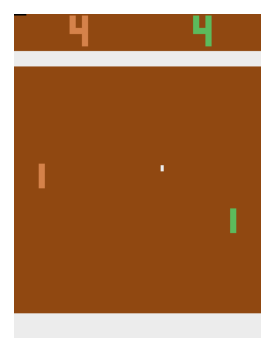

In [11]:
#model2 = pickle.load(open('save_tr.p', 'rb'))
#env = gym.make("Pong-v0")
play_game(env, model)